In [1]:
import sys
!{sys.executable} -m pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# =========================
# Cell 1: Imports & Setup
# =========================

# If needed (uncomment to install):
%pip install yfinance pandas numpy scipy matplotlib seaborn statsmodels arch

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
from arch import arch_model

plt.style.use("seaborn-v0_8")
np.random.seed(42)

# For consistent plots
def tight():
    plt.tight_layout()


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# =========================================
# Cell 2: Config — Tickers & Data Settings
# =========================================

TICKERS = {
    "^GSPC": "S&P 500",
    "QQQ": "QQQ",
    "^FTSE": "FTSE 100",
    "^N225": "Nikkei 225",
    "BTC-USD": "Bitcoin"
}

START = "1992-01-01"
END   = None    # None = up to latest
INTERVAL = "1d"

# Train/test split (proportion)
TRAIN_SPLIT = 0.8

# Rolling window for entropy (trading year)
ROLL_WIN = 252

# Permutation entropy params
PE_D = 4  # embedding dimension (3-6 typical)
PE_TAU = 1


In [5]:

# =========================================
# Cell 3: Data Download
# =========================================

import yfinance as yf
import pandas as pd
import numpy as np

# --- Parameters ---
tickers = ["^GSPC", "QQQ", "^FTSE", "^N225", "BTC-USD"]
start_date = "1992-01-01"
end_date = "2025-01-01"

data = {}
rets = {}

def compute_log_returns(price_series):
    """Compute log returns from a Series."""
    r = np.log(price_series).diff().dropna()
    r.name = "r"
    return r

# Download and prepare data
for t in tickers:
    print(f"Downloading {t}...")
    px = yf.download(t, start=start_date, end=end_date)

    # Skip tickers with missing or empty data
    if px.empty:
        print(f"Warning: insufficient data for {t}")
        continue

    # Store full OHLCV DataFrame
    data[t] = px.dropna(how="all")

    # Compute log returns from 'Close'
    close_series = pd.to_numeric(px["Close"].squeeze(), errors="coerce").dropna()
    if close_series.shape[0] < 2:
        print(f"Warning: insufficient rows for {t}")
        continue

    rets[t] = compute_log_returns(close_series)

print("✅ Data download, storage, and returns computation complete.")

# === Show sample data and returns for each ticker ===
for t in rets:
    print(f"\n=== {t} ({len(data[t])} price rows, {len(rets[t])} return rows) ===")
    print("📊 OHLCV sample:")
    print(data[t].head())  # full set of columns
    print("\n📉 Log returns sample:")
    print(rets[t].head())


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

✅ Data download, storage, and returns computation complete.

=== ^GSPC (8311 price rows, 8310 return rows) ===
📊 OHLCV sample:
Price            Close        High         Low        Open     Volume
Ticker           ^GSPC       ^GSPC       ^GSPC       ^GSPC      ^GSPC
Date                                                                 
1992-01-02  417.260010  417.269989  411.040009  417.029999  207570000
1992-01-03  419.339996  419.790009  416.160004  417.269989  224270000
1992-01-06  417.959991  419.440002  416.920013  419.309998  251210000
1992-01-07  417.399994  417.959991  415.200012  417.959991  252780000
1992-01-08  418.100006  420.230011  415.019989  417.359985  290750000

📉 Log returns sample:
Date
1992-01-03    0.004972
1992-01-06   -0.003296
1992-01-07   -0.001341
1992-01-08    0.001676
1992-01-09   -0.001173
Name: r, dtype: float64

=== QQQ (6496 price rows, 6495 return rows) ===
📊 OHLCV sample:
Price           Close       High        Low       Open   Volume
Ticker           

In [6]:
# =========================================
# Cell 4: Preprocessing, Alignment & Descriptive Stats
# =========================================

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch

# --- 4.1 Combine returns into wide DataFrames (union & intersection of dates) ---

# Union of dates (outer join) – keeps all available observations per asset
returns_union = pd.concat(rets, axis=1).sort_index()
returns_union.columns = list(rets.keys())

# Intersection of dates (inner join) – same timestamp across all assets
returns_aligned = pd.concat(rets, axis=1, join="inner").sort_index()
returns_aligned.columns = list(rets.keys())

print("✅ Returns combined.")
print(f"• returns_union shape:      {returns_union.shape} (keeps all available dates per asset)")
print(f"• returns_aligned shape:    {returns_aligned.shape} (strict intersection across assets)")

# --- 4.2 Basic sanity checks ---
# Drop rows where all returns are NaN (shouldn't happen, but safe)
returns_union = returns_union.dropna(how="all")
returns_aligned = returns_aligned.dropna(how="any")  # aligned must have all present

# --- 4.3 Helper functions for stats & tests ---

def annualize_vol(daily_vol, trading_days=252):
    """Annualize daily volatility."""
    return daily_vol * np.sqrt(trading_days)

def sharpe_ratio(daily_mean, daily_std, rf_daily=0.0, trading_days=252):
    """Annualized Sharpe (using daily mean/std)."""
    if daily_std == 0 or np.isnan(daily_std):
        return np.nan
    ann_ret = (daily_mean - rf_daily) * trading_days
    ann_vol = daily_std * np.sqrt(trading_days)
    return ann_ret / ann_vol

def series_stats(r):
    """Compute descriptive stats & tests for a return Series r."""
    r = pd.Series(r).dropna()
    n = r.shape[0]
    mu = r.mean()
    sd = r.std(ddof=1)

    # Moments
    sk = stats.skew(r, bias=False)
    kt = stats.kurtosis(r, fisher=True, bias=False)  # excess kurtosis

    # JB test for normality
    jb_stat, jb_p = stats.jarque_bera(r)

    # ADF test for stationarity (on returns; should generally be stationary)
    try:
        adf_res = adfuller(r, maxlag=None, regression='c', autolag='AIC')  # include constant
        adf_stat, adf_p = adf_res[0], adf_res[1]
    except Exception as e:
        adf_stat, adf_p = np.nan, np.nan

    # ARCH-LM test for conditional heteroskedasticity (lags=5)
    try:
        arch_stat, arch_p, _, _ = het_arch(r, nlags=5)
    except Exception as e:
        arch_stat, arch_p = np.nan, np.nan

    # Annualized stats (using 252 days; good for equities/ETFs; acceptable proxy for crypto here)
    ann_vol = annualize_vol(sd, trading_days=252)
    ann_sharpe = sharpe_ratio(mu, sd, rf_daily=0.0, trading_days=252)

    return {
        "n": n,
        "mean_daily": mu,
        "std_daily": sd,
        "skew": sk,
        "excess_kurtosis": kt,
        "ann_vol": ann_vol,
        "ann_sharpe": ann_sharpe,
        "jb_stat": jb_stat, "jb_p": jb_p,
        "adf_stat": adf_stat, "adf_p": adf_p,
        "arch_stat": arch_stat, "arch_p": arch_p,
        "min": r.min(), "max": r.max(),
        "p1": r.quantile(0.01), "p5": r.quantile(0.05),
        "p95": r.quantile(0.95), "p99": r.quantile(0.99)
    }

# --- 4.4 Descriptive statistics tables ---

def compute_table(df):
    out = {}
    for c in df.columns:
        out[c] = series_stats(df[c])
    return pd.DataFrame(out).T

desc_union = compute_table(returns_union)
desc_aligned = compute_table(returns_aligned)

# Order columns nicely
cols_order = [
    "n","mean_daily","std_daily","ann_vol","ann_sharpe",
    "skew","excess_kurtosis","min","p1","p5","p95","p99","max",
    "jb_stat","jb_p","adf_stat","adf_p","arch_stat","arch_p"
]
desc_union = desc_union.reindex(columns=cols_order)
desc_aligned = desc_aligned.reindex(columns=cols_order)

print("\n=== Descriptive Stats (Union of Dates) ===")
display(desc_union.round(6))

print("\n=== Descriptive Stats (Aligned Intersection) ===")
display(desc_aligned.round(6))

# --- 4.5 Correlation matrices (for aligned data) ---

corr_pearson = returns_aligned.corr(method="pearson")
corr_spearman = returns_aligned.corr(method="spearman")

print("\n=== Pearson Correlation (Aligned) ===")
display(corr_pearson.round(3))

print("\n=== Spearman Correlation (Aligned) ===")
display(corr_spearman.round(3))

# --- 4.6 Rolling volatility (store for later plots) ---

rolling_vol = returns_union.rolling(21).std() * np.sqrt(252)  # 21-day rolling, annualized
rolling_vol.columns = [f"{c}_annvol_21d" for c in rolling_vol.columns]

print("\n✅ Prepared rolling vol (21d), correlations, and descriptive stats.")


✅ Returns combined.
• returns_union shape:      (9664, 5) (keeps all available dates per asset)
• returns_aligned shape:    (2388, 5) (strict intersection across assets)

=== Descriptive Stats (Union of Dates) ===


n  mean_daily  std_daily   ann_vol  ann_sharpe      skew  \
^GSPC    8310.0    0.000318   0.011479  0.182226    0.440311 -0.410388   
QQQ      6495.0    0.000380   0.017097  0.271414    0.352744 -0.015349   
^FTSE    8334.0    0.000142   0.010961  0.174003    0.206347 -0.301764   
^N225    8099.0    0.000064   0.014617  0.232045    0.069258 -0.271294   
BTC-USD  3758.0    0.001416   0.036457  0.578737    0.616364 -0.724275   

         excess_kurtosis       min        p1        p5       p95       p99  \
^GSPC          10.871262 -0.127652 -0.032399 -0.017616  0.016355  0.030747   
QQQ             6.384080 -0.127592 -0.049246 -0.027788  0.025005  0.049136   
^FTSE           7.791019 -0.115117 -0.031702 -0.016798  0.016301  0.028464   
^N225           6.029929 -0.132341 -0.039493 -0.023047  0.021798  0.035738   
BTC-USD        11.396672 -0.464730 -0.107031 -0.057694  0.055905  0.101396   

              max       jb_stat  jb_p   adf_stat  adf_p    arch_stat  arch_p  
^GSPC    0.109572  41099.853428   0.0 -16.784698    0.0  2146.432673     0.0  
QQQ      0.155653  11009.814445   0.0 -19.326098    0.0  1069.485994     0.0  
^FTSE    0.093842  21175.331629   0.0 -16.396001    0.0  1544.621650     0.0  
^N225    0.132346  12351.157279   0.0 -93.167990    0.0  1253.848943     0.0  
BTC-USD  0.225119  20606.234774   0.0 -62.559716    0.0    90.171898     0.0


=== Descriptive Stats (Aligned Intersection) ===


n  mean_daily  std_daily   ann_vol  ann_sharpe      skew  \
^GSPC    2388.0    0.000455   0.011273  0.178958    0.641016 -0.822451   
QQQ      2388.0    0.000702   0.013719  0.217778    0.812485 -0.563156   
^FTSE    2388.0    0.000082   0.010028  0.159184    0.130132 -0.899390   
^N225    2388.0    0.000282   0.013105  0.208037    0.341829 -0.447216   
BTC-USD  2388.0    0.001132   0.039699  0.630202    0.452854 -0.878689   

         excess_kurtosis       min        p1        p5       p95       p99  \
^GSPC          16.295155 -0.127652 -0.032394 -0.016632  0.015726  0.025658   
QQQ             7.103047 -0.127592 -0.039128 -0.022316  0.021050  0.033731   
^FTSE          13.348019 -0.115117 -0.030885 -0.015259  0.014532  0.025314   
^N225           8.847932 -0.132341 -0.036860 -0.020533  0.019862  0.031054   
BTC-USD        11.857545 -0.464730 -0.117078 -0.061495  0.060162  0.103923   

              max       jb_stat  jb_p   adf_stat  adf_p   arch_stat  arch_p  
^GSPC    0.089683  26570.737150   0.0 -11.289009    0.0  967.508553     0.0  
QQQ      0.081309   5121.636570   0.0 -11.894532    0.0  668.679003     0.0  
^FTSE    0.086664  17968.641736   0.0 -49.754598    0.0  440.942015     0.0  
^N225    0.097366   7831.969984   0.0 -22.639797    0.0  436.203363     0.0  
BTC-USD  0.225119  14232.342888   0.0 -14.588170    0.0   63.241993     0.0


=== Pearson Correlation (Aligned) ===


^GSPC    QQQ  ^FTSE  ^N225  BTC-USD
^GSPC    1.000  0.929  0.545  0.213    0.228
QQQ      0.929  1.000  0.418  0.182    0.234
^FTSE    0.545  0.418  1.000  0.319    0.130
^N225    0.213  0.182  0.319  1.000    0.005
BTC-USD  0.228  0.234  0.130  0.005    1.000


=== Spearman Correlation (Aligned) ===


^GSPC    QQQ  ^FTSE  ^N225  BTC-USD
^GSPC    1.000  0.907  0.438  0.156    0.167
QQQ      0.907  1.000  0.339  0.142    0.175
^FTSE    0.438  0.339  1.000  0.255    0.059
^N225    0.156  0.142  0.255  1.000   -0.052
BTC-USD  0.167  0.175  0.059 -0.052    1.000


✅ Prepared rolling vol (21d), correlations, and descriptive stats.


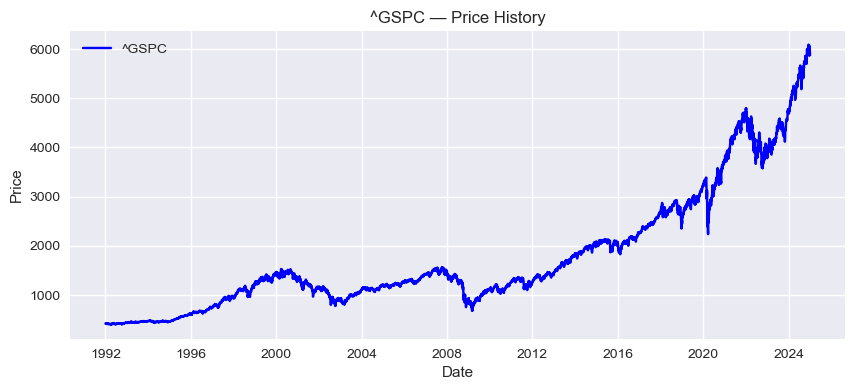

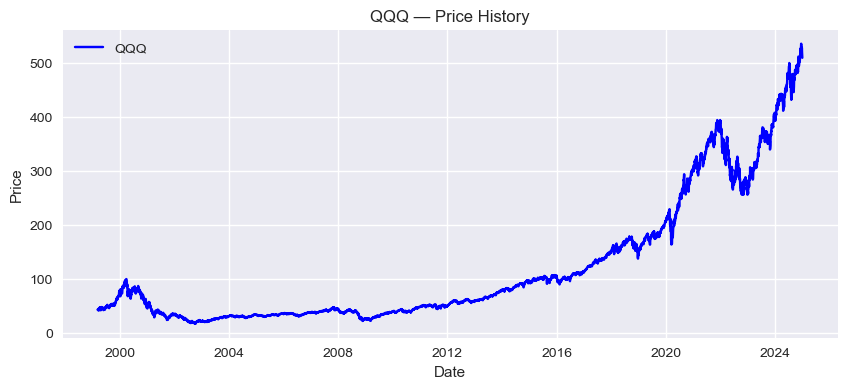

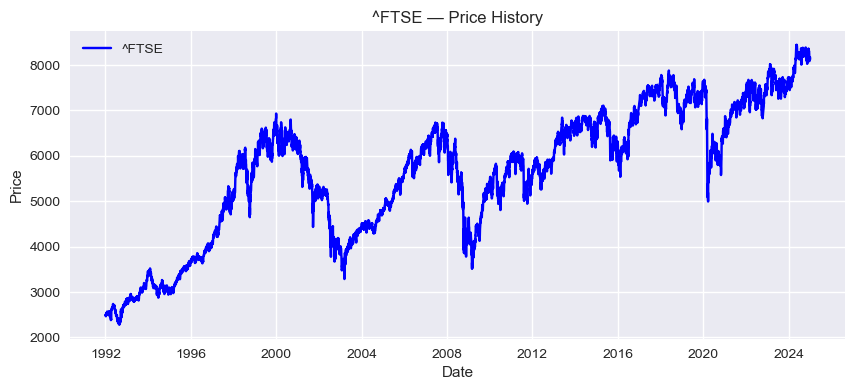

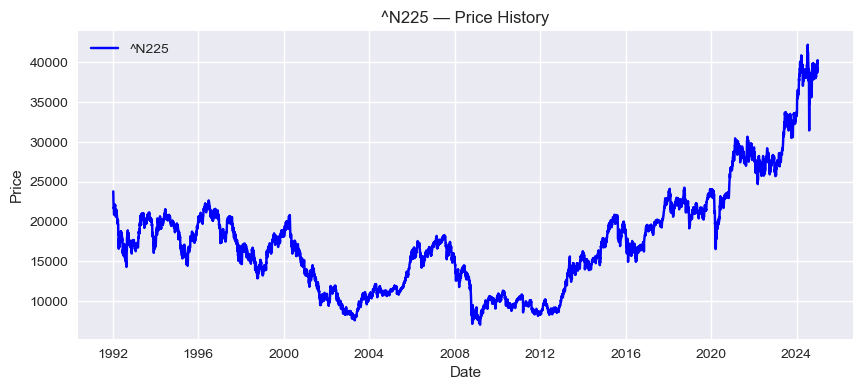

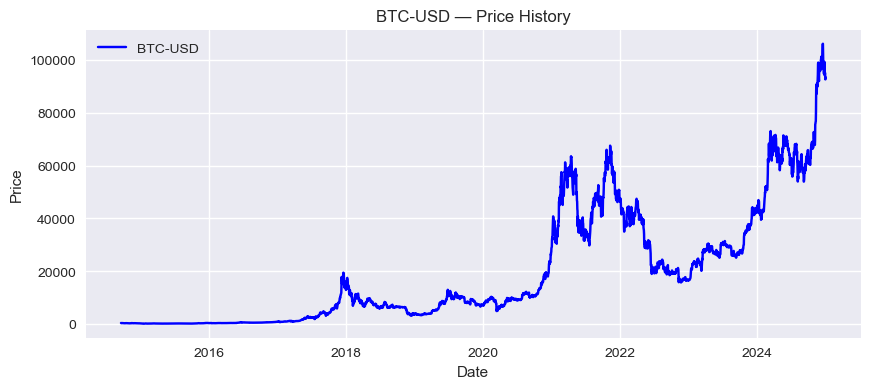

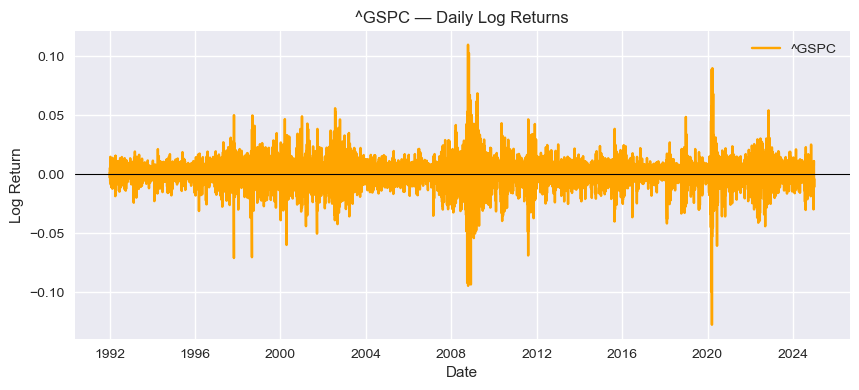

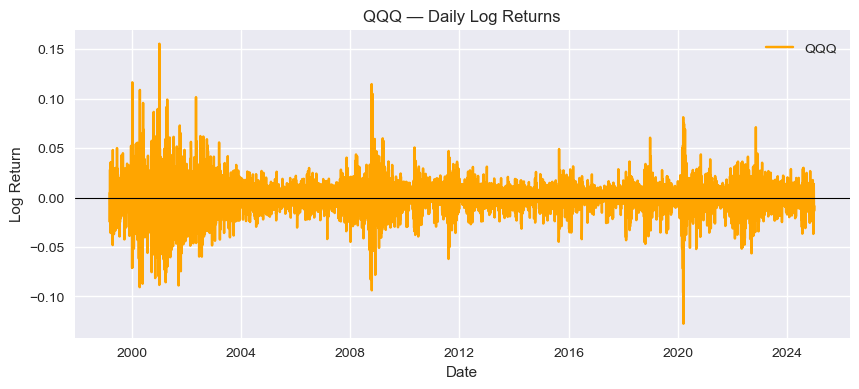

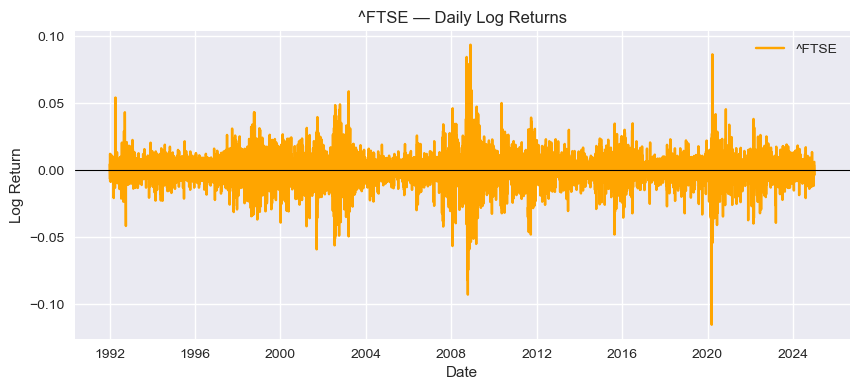

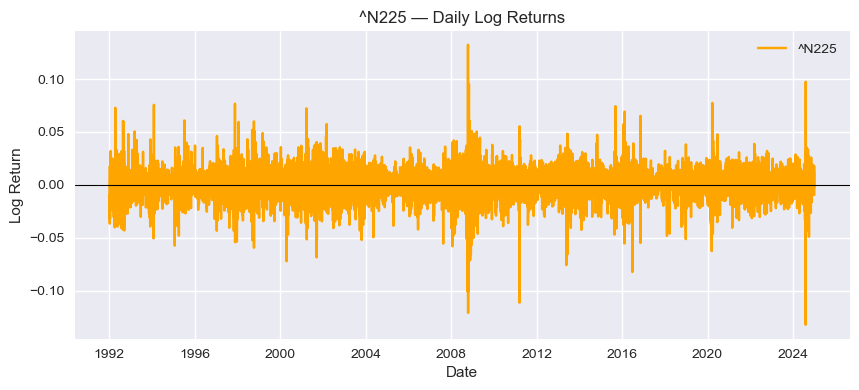

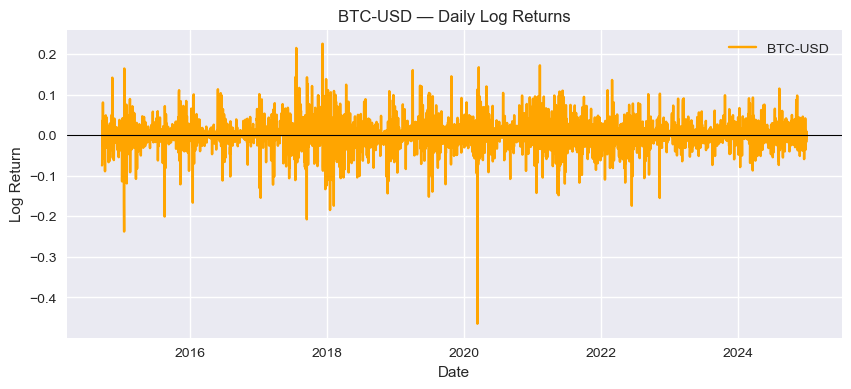

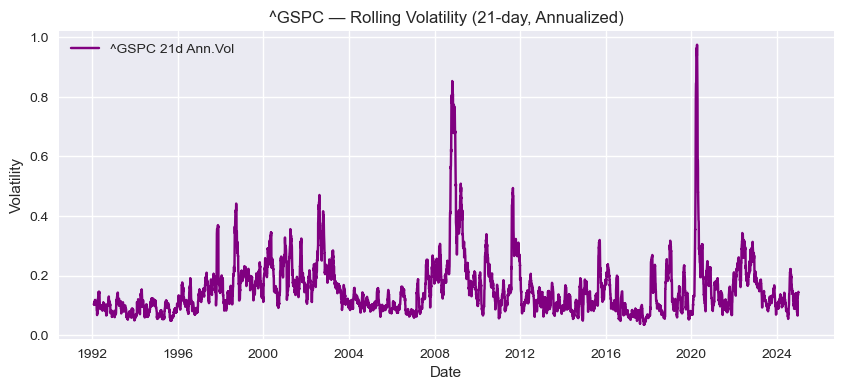

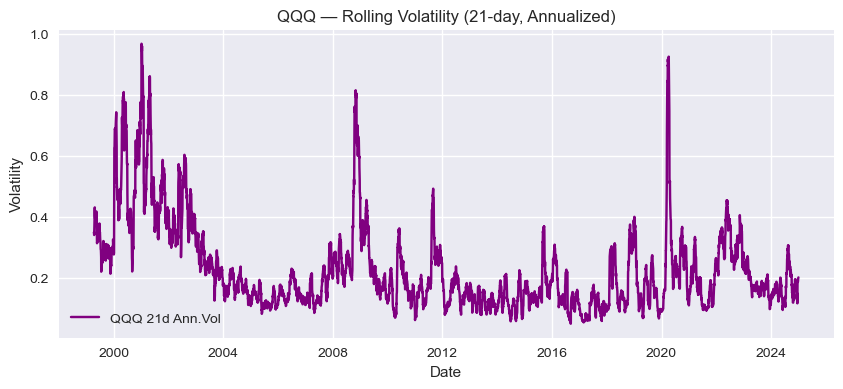

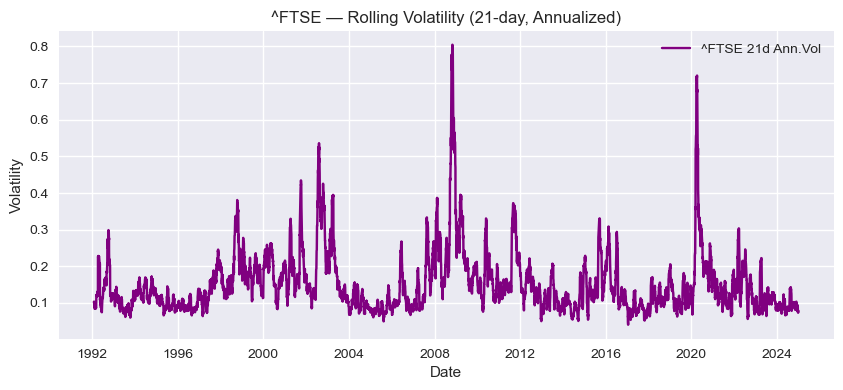

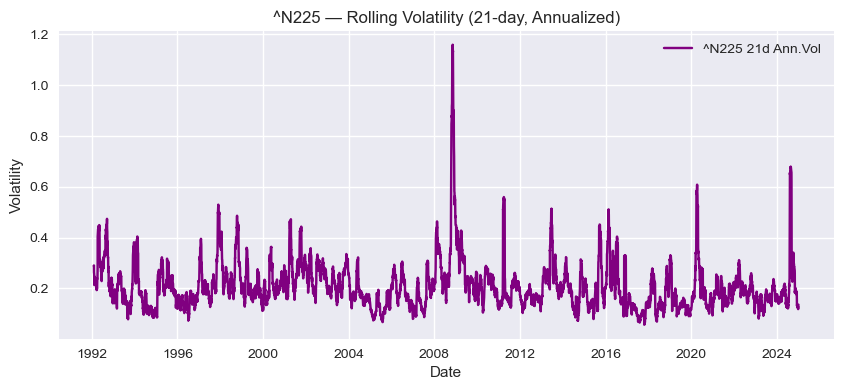

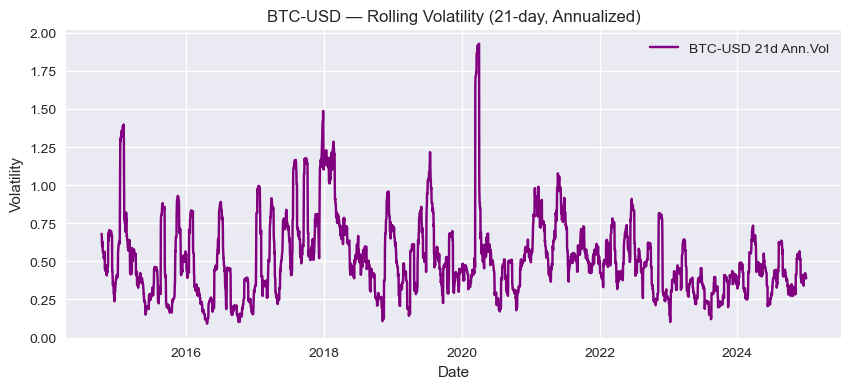

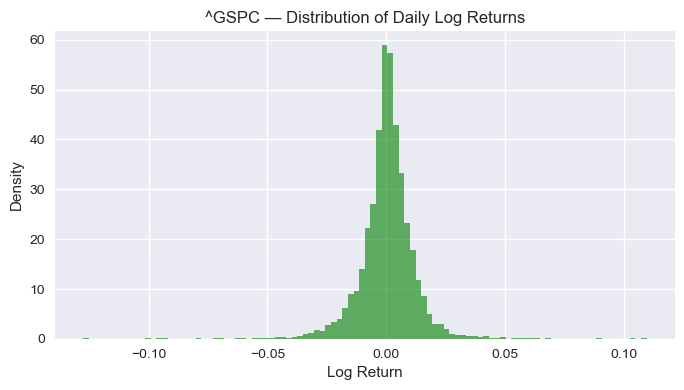

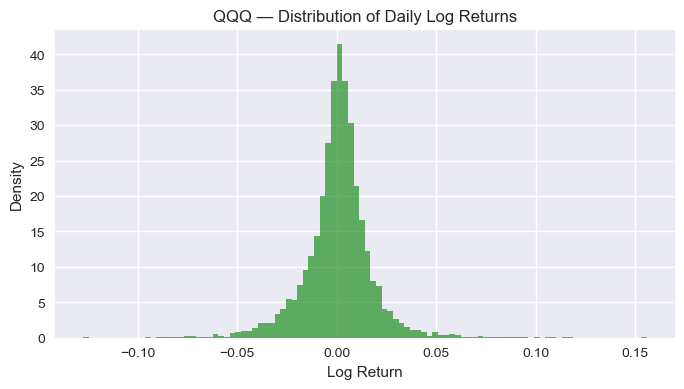

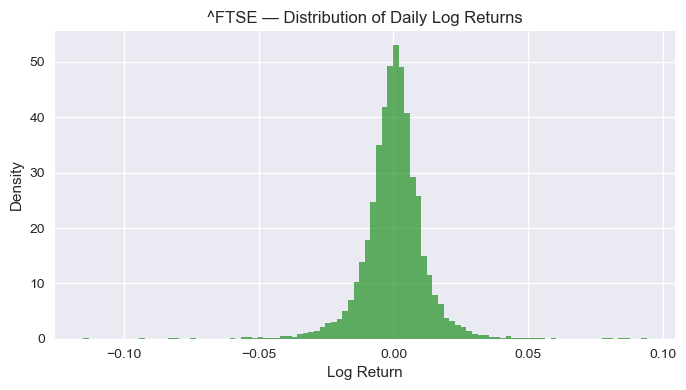

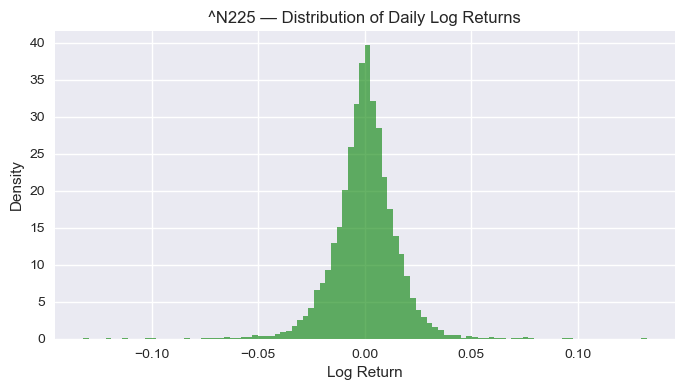

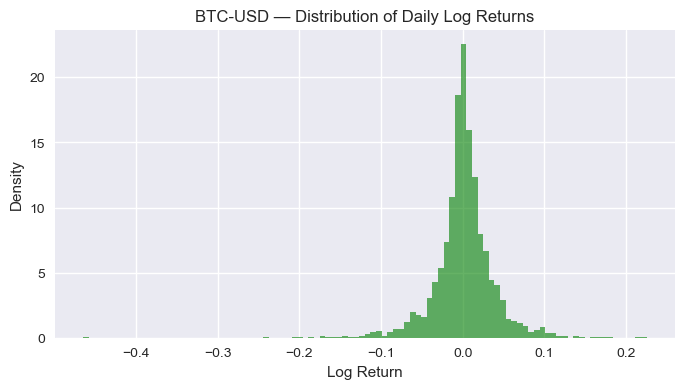

✅ Plotted prices, returns, rolling volatility, and return distributions.


In [7]:
# =========================================
# Cell 5: Visual Exploration of Price and Returns
# =========================================

import matplotlib.pyplot as plt

# --- 5.1 Plot price series for each ticker ---
for t in data.keys():
    plt.figure(figsize=(10, 4))
    plt.plot(data[t].index, data[t]["Close"], label=t, color="blue")
    plt.title(f"{t} — Price History")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend(); plt.grid(True)
    plt.show()

# --- 5.2 Plot log returns for each ticker ---
for t in rets.keys():
    plt.figure(figsize=(10, 4))
    plt.plot(rets[t].index, rets[t], label=t, color="orange")
    plt.title(f"{t} — Daily Log Returns")
    plt.xlabel("Date"); plt.ylabel("Log Return")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.legend(); plt.grid(True)
    plt.show()

# --- 5.3 Rolling volatility (21-day, annualized) ---
rolling_vol = {t: rets[t].rolling(21).std() * np.sqrt(252) for t in rets.keys()}

for t in rolling_vol.keys():
    plt.figure(figsize=(10, 4))
    plt.plot(rolling_vol[t].index, rolling_vol[t], label=f"{t} 21d Ann.Vol", color="purple")
    plt.title(f"{t} — Rolling Volatility (21-day, Annualized)")
    plt.xlabel("Date"); plt.ylabel("Volatility")
    plt.legend(); plt.grid(True)
    plt.show()

# --- 5.4 Return distributions (histograms) ---
for t in rets.keys():
    plt.figure(figsize=(8, 4))
    plt.hist(rets[t], bins=100, density=True, alpha=0.6, color="green")
    plt.title(f"{t} — Distribution of Daily Log Returns")
    plt.xlabel("Log Return"); plt.ylabel("Density")
    plt.grid(True)
    plt.show()

print("✅ Plotted prices, returns, rolling volatility, and return distributions.")



Processing ^GSPC...


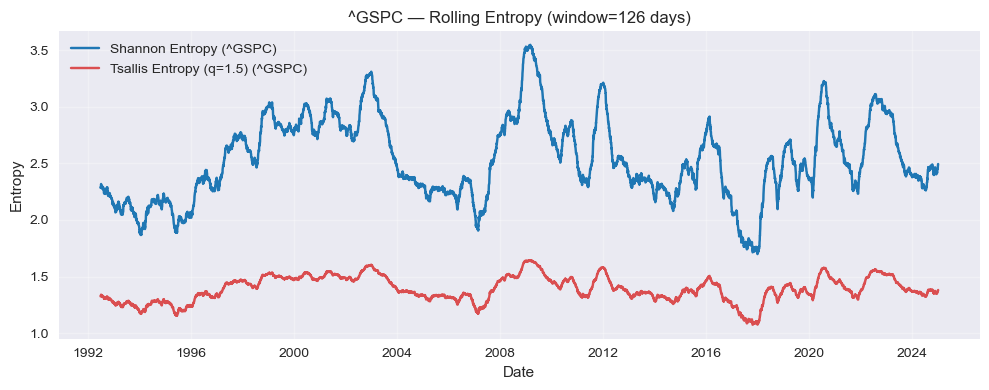

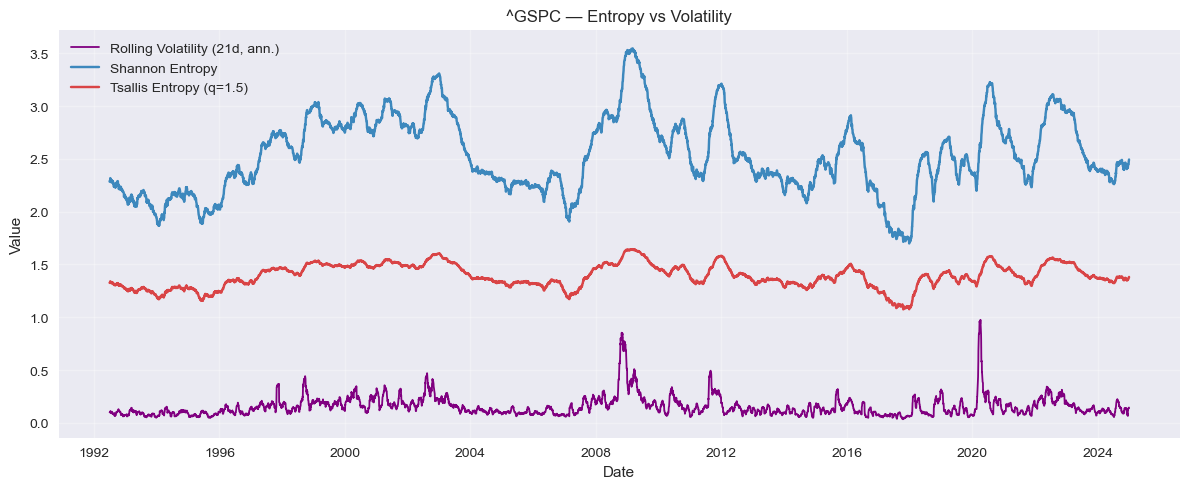

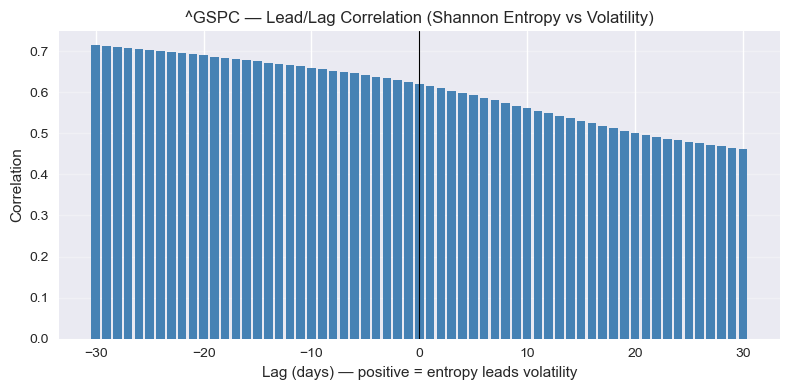


Processing QQQ...


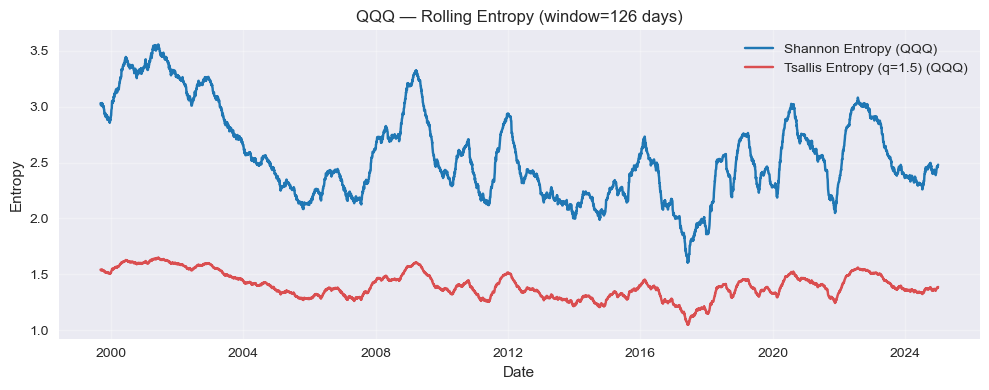

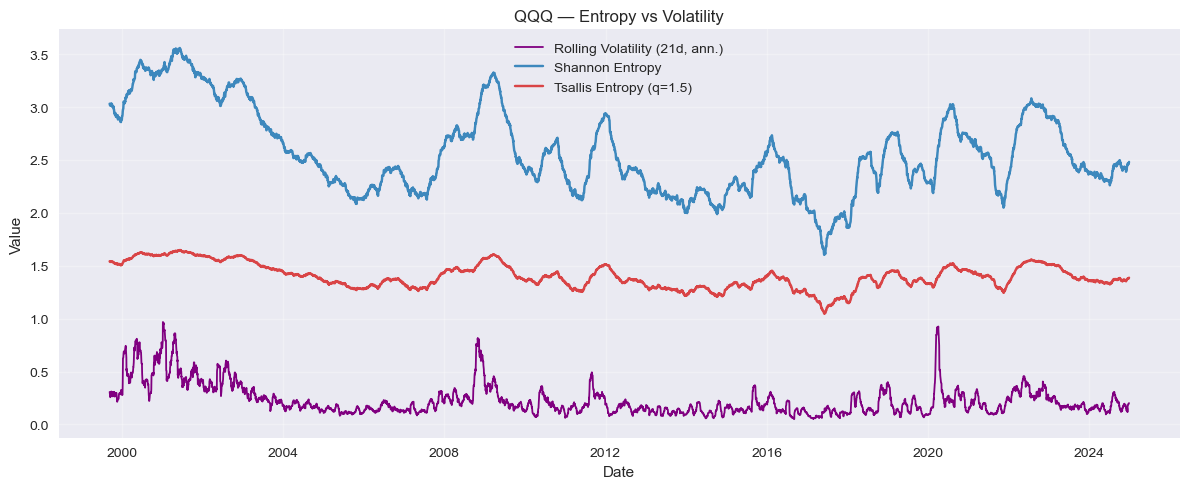

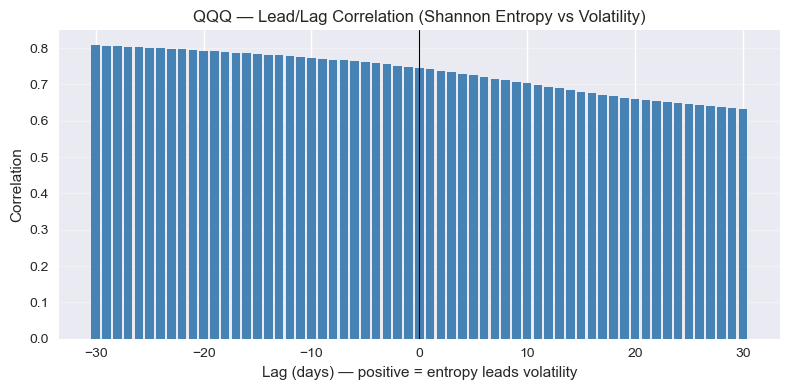


Processing ^FTSE...


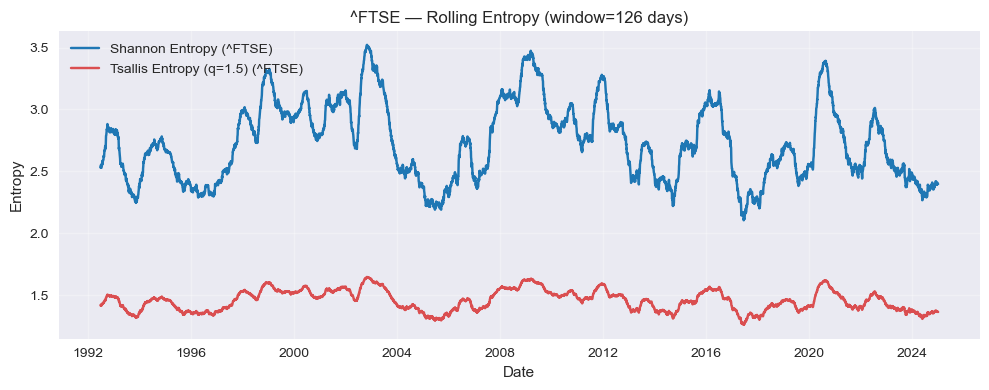

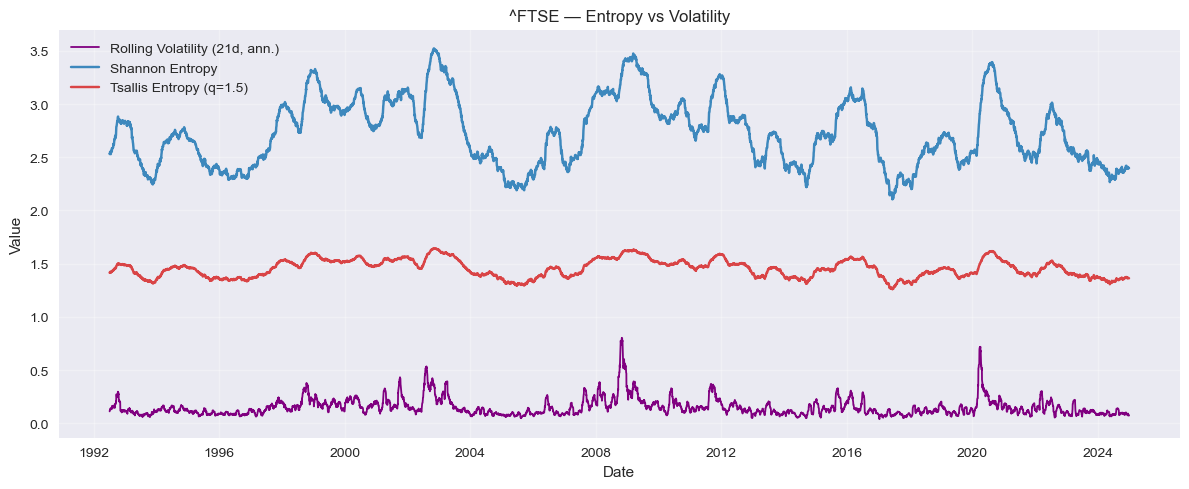

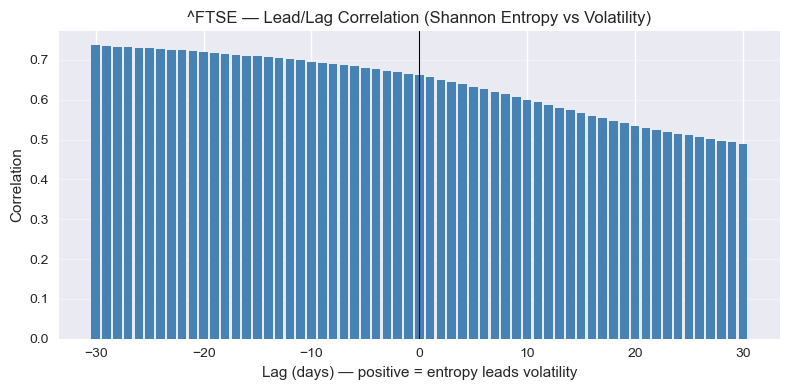


Processing ^N225...


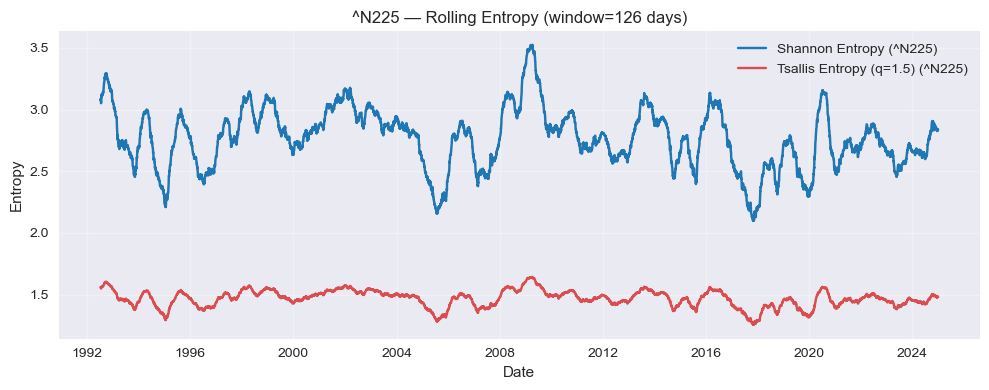

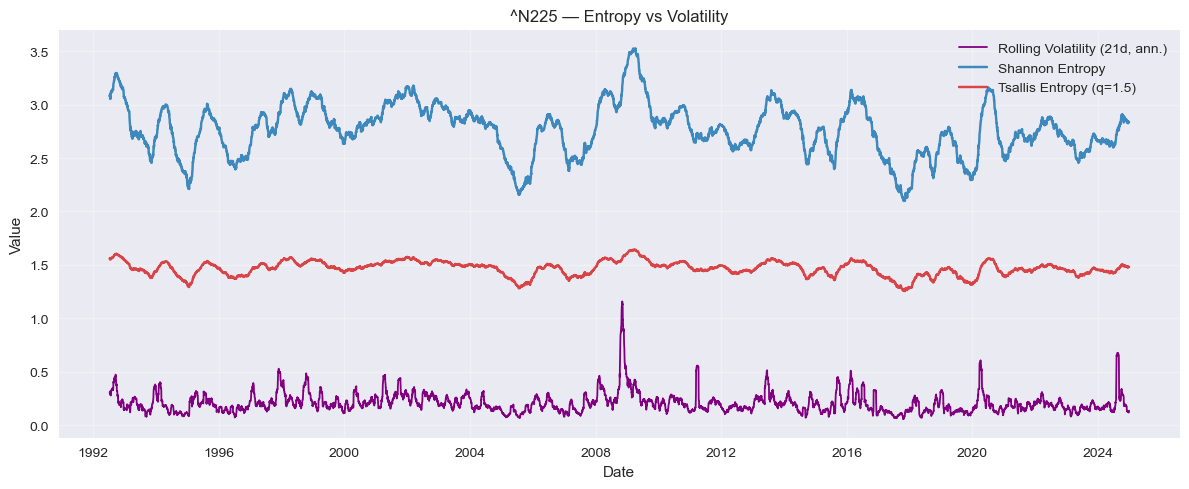

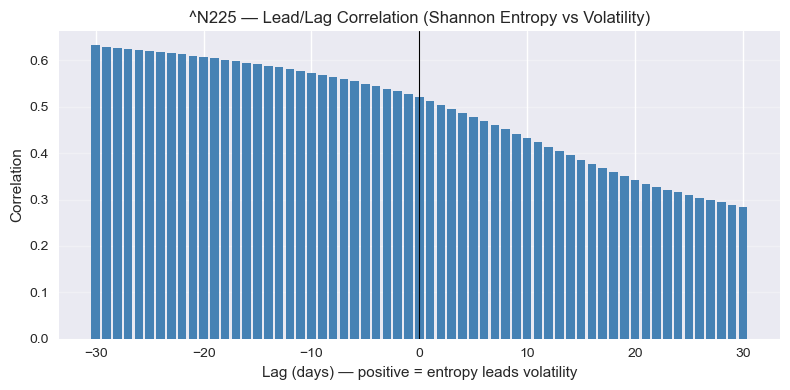


Processing BTC-USD...


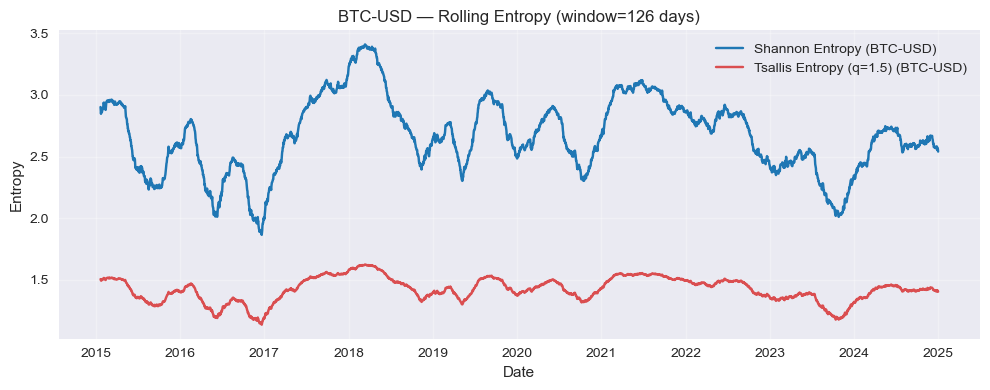

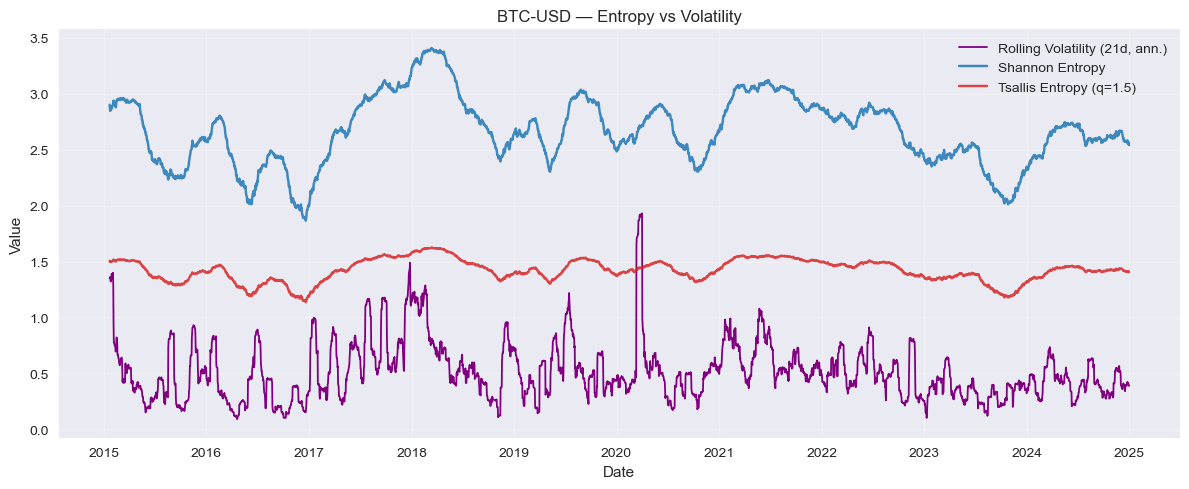

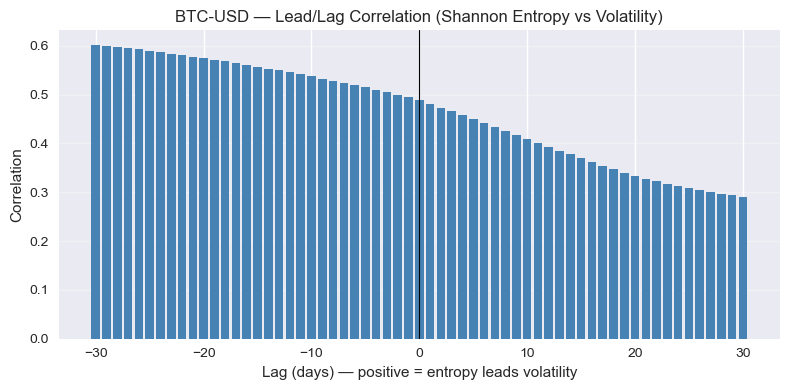

✅ Computed entropy with fixed bins, compared to volatility, and analyzed lead/lag relationships.


In [8]:
# =========================================
# Cell 6+7 (Reworked): Rolling Entropy (Shannon & Tsallis)
# + Volatility Comparison & Lead-Lag Analysis
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Helpers
# -----------------------------
def _fixed_bin_edges(x: pd.Series, nbins: int = 50, q_lo: float = 0.001, q_hi: float = 0.999):
    """
    Compute fixed bin edges for the whole series using robust quantiles.
    Falls back to min/max if quantiles collapse. Ensures strictly increasing edges.
    """
    x = pd.Series(x).dropna()
    if x.empty:
        # default symmetric tiny range to avoid failure
        return np.linspace(-1e-6, 1e-6, nbins + 1)
    lo = x.quantile(q_lo)
    hi = x.quantile(q_hi)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo = float(x.min())
        hi = float(x.max())
    if lo == hi:  # completely flat series
        lo, hi = lo - 1e-6, hi + 1e-6
    return np.linspace(lo, hi, nbins + 1)

def _hist_probs(chunk: np.ndarray, bin_edges: np.ndarray) -> np.ndarray:
    """
    Convert a window of returns to histogram probabilities using fixed edges.
    """
    counts, _ = np.histogram(chunk, bins=bin_edges)  # density=False
    total = counts.sum()
    if total <= 0:
        # return uniform (rare; degenerate window) to avoid NaNs
        return np.full_like(counts, 1.0 / len(counts), dtype=float)
    return counts.astype(float) / float(total)

def shannon_from_probs(p: np.ndarray) -> float:
    """
    Shannon entropy: H = -sum p log p  (natural log).
    Ignore zero-probability bins to avoid log(0).
    """
    p_nz = p[p > 0]
    if p_nz.size == 0:
        return 0.0
    return float(-(p_nz * np.log(p_nz)).sum())

def tsallis_from_probs(p: np.ndarray, q: float = 1.5) -> float:
    """
    Tsallis entropy: H_T(q) = (1 - sum p^q) / (q - 1)
    q -> 1 recovers Shannon.
    """
    if q == 1.0:
        return shannon_from_probs(p)
    return float((1.0 - (p ** q).sum()) / (q - 1.0))

def rolling_entropy(series: pd.Series, window: int, bin_edges: np.ndarray,
                    which: str = "shannon", q: float = 1.5) -> pd.Series:
    """
    Rolling entropy with fixed bin edges.
    which: "shannon" or "tsallis"
    """
    s = pd.Series(series).dropna()
    vals = s.values
    idxs = s.index

    out_vals = []
    out_idx = []
    for i in range(window, len(vals) + 1):
        chunk = vals[i - window:i]
        p = _hist_probs(chunk, bin_edges)
        if which == "shannon":
            H = shannon_from_probs(p)
        else:
            H = tsallis_from_probs(p, q=q)
        out_vals.append(H)
        out_idx.append(idxs[i - 1])
    return pd.Series(out_vals, index=out_idx)

# -----------------------------
# Parameters
# -----------------------------
ROLL_ENT_WIN = 126   # ~6 months
ROLL_VOL_WIN = 21    # ~1 month
BINS = 50
Q_PARAM = 1.5
LAGS = range(-30, 31)  # -30..+30 days

# -----------------------------
# Inputs
# -----------------------------
# Expect: rets = {ticker: pd.Series of returns with DateTimeIndex, ...}
# Example to build 'rets' from a price DataFrame 'price_df' with columns as tickers:
# price_df = ...  # DataFrame of adjusted close prices
# rets = {c: price_df[c].pct_change().dropna() for c in price_df.columns}

assert isinstance(rets, dict) and len(rets) > 0, "rets must be a dict of pd.Series (returns)."

# -----------------------------
# Storage
# -----------------------------
entropy_results = {}
lead_lag_results = {}

# -----------------------------
# Main loop
# -----------------------------
for t, r in rets.items():
    print(f"\nProcessing {t}...")

    # 0) Fixed bin edges per asset (robust)
    bin_edges = _fixed_bin_edges(r, nbins=BINS, q_lo=0.001, q_hi=0.999)

    # 1) Rolling entropies
    shannon_series = rolling_entropy(r, window=ROLL_ENT_WIN, bin_edges=bin_edges,
                                     which="shannon", q=Q_PARAM)
    tsallis_series  = rolling_entropy(r, window=ROLL_ENT_WIN, bin_edges=bin_edges,
                                     which="tsallis", q=Q_PARAM)
    entropy_results[t] = {"Shannon": shannon_series, "Tsallis": tsallis_series}

    # 2) Plot entropy evolution
    plt.figure(figsize=(10, 4))
    plt.plot(shannon_series, label=f"Shannon Entropy ({t})", color="tab:blue")
    plt.plot(tsallis_series,  label=f"Tsallis Entropy (q={Q_PARAM}) ({t})", color="tab:red", alpha=0.8)
    plt.title(f"{t} — Rolling Entropy (window={ROLL_ENT_WIN} days)")
    plt.xlabel("Date"); plt.ylabel("Entropy")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # 3) Rolling volatility (annualized)
    vol_series = r.rolling(ROLL_VOL_WIN).std() * np.sqrt(252)

    # 4) Combine
    combined_df = pd.concat([
        shannon_series.rename("Shannon"),
        tsallis_series.rename(f"Tsallis_q{Q_PARAM}"),
        vol_series.rename("Volatility")
    ], axis=1).dropna()

    # 5) Plot entropy vs volatility
    plt.figure(figsize=(12, 5))
    plt.plot(combined_df.index, combined_df["Volatility"], color="purple", lw=1.3,
             label=f"Rolling Volatility ({ROLL_VOL_WIN}d, ann.)")
    plt.plot(combined_df.index, combined_df["Shannon"], color="tab:blue", alpha=0.85, label="Shannon Entropy")
    plt.plot(combined_df.index, combined_df[f"Tsallis_q{Q_PARAM}"], color="tab:red", alpha=0.85,
             label=f"Tsallis Entropy (q={Q_PARAM})")
    plt.title(f"{t} — Entropy vs Volatility")
    plt.xlabel("Date"); plt.ylabel("Value")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # 6) Lead–lag correlation (Shannon vs Volatility)
    lag_corrs = {}
    for lag in LAGS:
        if lag > 0:
            # positive lag: entropy leads volatility by 'lag' days
            corr = combined_df["Shannon"].shift(lag).corr(combined_df["Volatility"])
        elif lag < 0:
            # negative lag: volatility leads entropy by |lag| days
            corr = combined_df["Shannon"].corr(combined_df["Volatility"].shift(-lag))
        else:
            corr = combined_df["Shannon"].corr(combined_df["Volatility"])
        lag_corrs[lag] = corr

    lead_lag_results[t] = lag_corrs

    # 7) Plot lead–lag
    plt.figure(figsize=(8, 4))
    plt.bar(list(lag_corrs.keys()), list(lag_corrs.values()), color="steelblue")
    plt.axvline(0, color="black", lw=0.8)
    plt.title(f"{t} — Lead/Lag Correlation (Shannon Entropy vs Volatility)")
    plt.xlabel("Lag (days) — positive = entropy leads volatility")
    plt.ylabel("Correlation")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout(); plt.show()

print("✅ Computed entropy with fixed bins, compared to volatility, and analyzed lead/lag relationships.")

# -----------------------------
# (Optional) Pack results into DataFrames for export
# -----------------------------
# Example: extract lead-lag into a DataFrame (rows: lags, columns: tickers)
lags_sorted = sorted(LAGS)
lead_lag_df = pd.DataFrame({t: [lead_lag_results[t].get(l, np.nan) for l in lags_sorted]}
                           , index=lags_sorted)
lead_lag_df.index.name = "Lag"


In [9]:
# =========================================
# Cell 8: Simulation Utilities for GBM, GARCH, Langevin, OU, and FP-inspired SDE
# =========================================

import numpy as np
import pandas as pd
from dataclasses import dataclass
from scipy import stats
from numpy.linalg import lstsq

# GARCH
try:
    from arch import arch_model
except Exception as e:
    raise ImportError("arch library is required for GARCH. Install with: pip install arch") from e

np.random.seed(42)

# ---------- Helpers ----------
def _fit_mu_sigma_from_returns(r):
    r = pd.Series(r).dropna()
    return float(r.mean()), float(r.std(ddof=1))

def _logprice(series_close):
    return np.log(pd.Series(series_close).dropna())

def _fit_ar1(y):
    """
    Fit y_{t+1} = a + b y_t + eps via OLS.
    Returns (a, b, resid_std).
    """
    y = pd.Series(y).dropna().values
    X = np.vstack([np.ones(len(y)-1), y[:-1]]).T
    beta, _, _, _ = lstsq(X, y[1:], rcond=None)
    resid = y[1:] - X @ beta
    a, b = beta[0], beta[1]
    s = float(np.std(resid, ddof=1))
    return a, b, s

# ---------- GBM ----------
@dataclass
class GBMParams:
    mu: float
    sigma: float

def simulate_gbm(S0, mu, sigma, n_steps, dt=1.0):
    S = np.empty(n_steps + 1)
    S[0] = S0
    for t in range(1, n_steps + 1):
        z = np.random.normal()
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return pd.Series(S)

# ---------- GARCH(1,1) ----------
def fit_garch(r, mean_model='Zero'):
    r_pct = pd.Series(r).dropna() * 100  # arch expects percent
    am = arch_model(r_pct, vol='Garch', p=1, q=1, mean=mean_model, dist='normal')
    res = am.fit(disp='off')
    return res

def simulate_garch(res, n_steps, start_vol=None, mean_model='Zero'):
    """
    Simulate standardized shocks from the fitted GARCH model and rebuild returns.
    Returns daily log-returns (not percent).
    """
    sim = res.simulate(res.params, nobs=n_steps)
    # mean term
    if mean_model.lower() == 'constant':
        mu = res.params.get('mu', 0.0)
    else:
        mu = 0.0
    # eps in percent -> convert back to log-return
    r_pct = mu + sim['data']  # already includes sigma_t * z_t
    return pd.Series(r_pct / 100.0)

# ---------- Langevin (in returns): dr = -gamma r dt + sigma dW ----------
@dataclass
class LangevinParams:
    gamma: float
    sigma: float
    a: float  # constant drift in returns (optional)

def fit_langevin_returns(r):
    """
    Discrete: r_{t+1} = a + (1 - gamma) r_t + eps
    Fit AR(1) to returns; gamma = 1 - phi, sigma = resid_std
    """
    a, phi, s = _fit_ar1(pd.Series(r).dropna())
    gamma = 1.0 - phi
    return LangevinParams(gamma=max(1e-6, gamma), sigma=max(1e-8, s), a=a)

def simulate_langevin_returns(r0, params: LangevinParams, n_steps, dt=1.0):
    r = np.empty(n_steps)
    rt = r0
    for t in range(n_steps):
        z = np.random.normal()
        rt = params.a + (1.0 - params.gamma) * rt + params.sigma * np.sqrt(dt) * z
        r[t] = rt
    return pd.Series(r)

# ---------- OU on log-price: dp = kappa (mu - p) dt + sigma dW ----------
@dataclass
class OUParams:
    kappa: float
    mu: float
    sigma: float

def fit_ou_logprice(p_log):
    """
    Discrete: p_{t+1} - p_t = kappa (mu - p_t) + eps
    => Δp_{t+1} = a + b * p_t + eps, with a = kappa*mu, b = -kappa
    """
    p = _logprice(p_log)
    dp = p.diff().dropna()
    X = np.vstack([np.ones(len(dp)), p[:-1].values]).T
    beta, _, _, _ = lstsq(X, dp.values, rcond=None)
    a, b = beta
    kappa = max(1e-6, -b)
    mu = a / kappa if kappa > 0 else p.mean()
    resid = dp.values - (X @ beta)
    sigma = float(np.std(resid, ddof=1))
    return OUParams(kappa=kappa, mu=mu, sigma=max(1e-8, sigma)), p.index

def simulate_ou_logprice(p0, params: OUParams, n_steps, dt=1.0):
    p = np.empty(n_steps + 1)
    p[0] = p0
    for t in range(1, n_steps + 1):
        z = np.random.normal()
        dp = params.kappa * (params.mu - p[t-1]) * dt + params.sigma * np.sqrt(dt) * z
        p[t] = p[t-1] + dp
    return pd.Series(p)

# ---------- FP-inspired path via data-driven drift/diffusion in returns ----------
def estimate_kramers_moyal(r, n_bins=25, min_count=40):
    """
    State x_t = r_t; Δx = r_{t+1} - r_t
    Estimate a(x)=E[Δx|x], b^2(x)=Var(Δx|x)
    """
    r = pd.Series(r).dropna().values
    x = r[:-1]; dx = r[1:] - r[:-1]
    bins = np.quantile(x, np.linspace(0.01, 0.99, n_bins+1))
    cat = pd.cut(x, bins=bins, include_lowest=True)
    df = pd.DataFrame({'x': x, 'dx': dx, 'bin': cat})
    g = df.groupby('bin')
    centers = g['x'].mean()
    a_hat = g['dx'].mean()
    b2_hat = g['dx'].var()
    count = g['dx'].count()
    mask = count >= min_count
    return centers[mask].values, a_hat[mask].values, np.maximum(b2_hat[mask].values, 1e-10)

def simulate_fp_path_from_km(r0, centers, a_hat, b2_hat, n_steps, dt=1.0):
    """
    Euler–Maruyama using state-dependent a(x), b(x) inferred from data (Kramers–Moyal).
    """
    def a_of(x):
        return np.interp(x, centers, a_hat, left=a_hat[0], right=a_hat[-1])
    def b_of(x):
        return np.sqrt(np.interp(x, centers, b2_hat, left=b2_hat[0], right=b2_hat[-1]))

    r = np.empty(n_steps)
    rt = r0
    for t in range(n_steps):
        z = np.random.normal()
        rt = rt + a_of(rt) * dt + b_of(rt) * np.sqrt(dt) * z
        r[t] = rt
    return pd.Series(r)


In [15]:
# =========================================
# Cell 9 A (fixed): Fit Models per Ticker & Simulate *Multiple* Paths
#  - n_paths ensemble with reproducible seeds
#  - Start at FIRST price of the test window for fairness
#  - Produce aggregated (median) series + retain full runs
#  - Index-aligned outputs
# =========================================

import numpy as np
import pandas as pd
from dataclasses import dataclass

# ---------- Config ----------
n_paths = 500
global_seed = 20250829  # fixed seed for reproducibility

# ---------- Utilities ----------
def _to_1d(a) -> np.ndarray:
    """Flatten any array/Series/DataFrame column to 1-D float ndarray."""
    if isinstance(a, pd.DataFrame):
        a = a.iloc[:, 0]
    return np.asarray(a, dtype=float).reshape(-1)

def _rets_to_price(S0: float, ret_series: pd.Series) -> pd.Series:
    """
    Convert log-returns to a synthetic price path with the SAME LENGTH/INDEX as ret_series.
    The first price corresponds to S0 * exp(r1).
    """
    r = pd.Series(ret_series).dropna()
    p = np.exp(r.cumsum()) * float(S0)
    p.index = r.index
    return p

def _median_series(index_like, values_2d):
    """Return a Series of the timewise median across axis=0 for a 2D array."""
    med = np.nanmedian(values_2d, axis=0)
    return pd.Series(med, index=index_like)

def _mean_series(index_like, values_2d):
    """Return a Series of the timewise mean across axis=0 for a 2D array."""
    m = np.nanmean(values_2d, axis=0)
    return pd.Series(m, index=index_like)

# ---------- Manual GARCH(1,1) simulator (version-agnostic) ----------
def _pick_param(params, startswith_list, default=None):
    idx = params.index.astype(str).str.lower()
    for pfx in [p.lower() for p in startswith_list]:
        hits = [i for i, name in enumerate(idx) if name.startswith(pfx)]
        if hits:
            return float(params.iloc[hits[0]])
    if default is not None:
        return default
    raise KeyError(f"Param not found; looked for any of {startswith_list} in {list(params.index)}")

def simulate_garch_manual(res, n_steps, mean_model='Zero', index=None, random_state=42):
    """
    Simulate returns from fitted GARCH(1,1) parameters without relying on res.simulate().
    Returns a pandas Series of log-returns aligned to `index` (if provided).
    """
    rng = np.random.default_rng(random_state)
    params = res.params

    omega = _pick_param(params, ['omega'])
    alpha = _pick_param(params, ['alpha[', 'alpha'])
    beta  = _pick_param(params, ['beta[',  'beta'])

    mu = 0.0
    if mean_model.lower() == 'constant':
        try:
            mu = _pick_param(params, ['mu', 'const'], default=0.0)
        except KeyError:
            mu = 0.0

    # starting variance: last fitted cond vol if available, else unconditional
    try:
        last_sigma = float(getattr(res, 'conditional_volatility')[-1])
        var_prev = last_sigma**2
    except Exception:
        denom = max(1e-10, 1.0 - alpha - beta)
        var_prev = omega / denom

    r = np.zeros(n_steps)
    eps_prev = 0.0

    for t in range(n_steps):
        var_t = omega + alpha * (eps_prev ** 2) + beta * var_prev
        var_t = max(var_t, 1e-16)
        z = rng.standard_normal()
        eps_t = np.sqrt(var_t) * z
        r[t] = (mu + eps_t) if mean_model.lower() == 'constant' else eps_t
        eps_prev, var_prev = eps_t, var_t

    out = pd.Series(r, index=index[:n_steps] if isinstance(index, (pd.Index, pd.DatetimeIndex)) else None, name='r_garch_sim')
    return out

# ---------- OU (log-price) fit + simulate already defined earlier ----------
# We re-use: fit_ou_logprice(close_series, dt=1.0) -> OUParams, info
#            simulate_ou_logprice(p0_log, params, n_steps, dt, index, seed)

# ---------- MAIN: Ensemble fit & simulate per ticker ----------
sim_results = {}         # aggregated (median) Series per ticker/model for convenient access
sim_returns = {}         # aggregated returns Series per ticker/model (median)
sim_prices  = {}         # aggregated price Series per ticker/model (median; includes GBM/OU and price-recon for returns-based models)

# Keep all runs for later evaluation/plots (metrics across runs, fan charts, etc.)
sim_returns_runs = {}    # per t: dict(model -> 2D array [n_paths, n_steps])
sim_prices_runs  = {}    # per t: dict(model -> 2D array [n_paths, n_steps] OR [n_paths, n_steps+1] depending on construction)
sim_dispersion   = {}    # per t: dict(model -> dict with 'std' etc.)

rng_master = np.random.default_rng(global_seed)

for t in rets.keys():
    print(f"\n=== {t}: fitting & simulating ({n_paths} runs/model) ===")
    r = rets[t].dropna()
    n_steps = len(r)

    # ---- Ensure clean close series & anchors ----
    close_obj = data[t]["Close"]
    if isinstance(close_obj, pd.DataFrame):
        close_obj = close_obj.iloc[:, 0]
    actual_price = pd.to_numeric(pd.Series(np.ravel(close_obj)), errors="coerce").dropna()
    # align index back
    actual_price.index = pd.Index(close_obj.index[:len(actual_price)]) if hasattr(close_obj, "index") else actual_price.index

    # Start at FIRST observed price for fairness
    S_start = float(actual_price.iloc[0])
    p0_log_start = float(np.log(S_start))

    # Indices
    price_index_full = actual_price.index[:(n_steps + 1)]   # prices have n_steps+1 when simulated directly
    returns_index = r.index                                 # returns have length n_steps

    # ---------- GBM ----------
    mu_gbm = float(r.mean())
    sig_gbm = float(r.std(ddof=1))
    gbm_price_runs = np.empty((n_paths, n_steps + 1), dtype=float)
    gbm_rets_runs  = np.empty((n_paths, n_steps), dtype=float)

    # derive seeds for this model
    child_ss = np.random.SeedSequence(rng_master.integers(0, 2**32-1))
    gbm_seeds = child_ss.spawn(n_paths)

    for i in range(n_paths):
        path = simulate_gbm(S_start, mu_gbm, sig_gbm, n_steps=n_steps, dt=1.0)  # length n_steps+1
        path.index = price_index_full
        gbm_price_runs[i, :] = path.values
        gbm_rets_runs[i, :] = np.log(path).diff().dropna().values  # length n_steps

    # aggregated
    gbm_price_med = _median_series(price_index_full, gbm_price_runs)
    gbm_rets_med  = _median_series(returns_index, gbm_rets_runs)

    # ---------- GARCH(1,1) ----------
    g0 = fit_garch(r, mean_model='Zero')
    gd = fit_garch(r, mean_model='Constant')

    garch0_ret_runs = np.empty((n_paths, n_steps), dtype=float)
    garchd_ret_runs = np.empty((n_paths, n_steps), dtype=float)
    garch0_price_runs = np.empty((n_paths, n_steps), dtype=float)  # reconstructed price (length = n_steps, same as returns_index)
    garchd_price_runs = np.empty((n_paths, n_steps), dtype=float)

    child_ss = np.random.SeedSequence(rng_master.integers(0, 2**32-1))
    garch_seeds = child_ss.spawn(2 * n_paths)  # half for zero-mean, half for drift

    for i in range(n_paths):
        # zero-mean
        ret0 = simulate_garch_manual(g0, n_steps=n_steps, mean_model='Zero', index=returns_index, random_state=int(garch_seeds[i].generate_state(1)[0]))
        garch0_ret_runs[i, :] = ret0.values
        garch0_price_runs[i, :] = _rets_to_price(S_start, ret0).values

        # with drift
        retd = simulate_garch_manual(gd, n_steps=n_steps, mean_model='Constant', index=returns_index, random_state=int(garch_seeds[n_paths + i].generate_state(1)[0]))
        garchd_ret_runs[i, :] = retd.values
        garchd_price_runs[i, :] = _rets_to_price(S_start, retd).values

    garch0_ret_med   = _median_series(returns_index, garch0_ret_runs)
    garchd_ret_med   = _median_series(returns_index, garchd_ret_runs)
    garch0_price_med = _median_series(returns_index, garch0_price_runs)
    garchd_price_med = _median_series(returns_index, garchd_price_runs)

    # ---------- Langevin on returns ----------
    lan_params = fit_langevin_returns(r)
    lan_ret_runs = np.empty((n_paths, n_steps), dtype=float)
    lan_price_runs = np.empty((n_paths, n_steps), dtype=float)

    child_ss = np.random.SeedSequence(rng_master.integers(0, 2**32-1))
    lan_seeds = child_ss.spawn(n_paths)

    r0 = float(r.iloc[0]) if len(r) > 0 else 0.0  # start return state at first obs
    for i in range(n_paths):
        rr = simulate_langevin_returns(r0, lan_params, n_steps=n_steps, dt=1.0)
        rr.index = returns_index
        lan_ret_runs[i, :] = rr.values
        lan_price_runs[i, :] = _rets_to_price(S_start, rr).values

    lan_ret_med   = _median_series(returns_index, lan_ret_runs)
    lan_price_med = _median_series(returns_index, lan_price_runs)

    # ---------- OU on log-price (AR(1) on log-price mapping) ----------
    try:
        ou_params, _info = fit_ou_logprice(actual_price, dt=1.0)   # robust fit on 1-D close series
        ou_price_runs = np.empty((n_paths, n_steps + 1), dtype=float)
        ou_ret_runs   = np.empty((n_paths, n_steps), dtype=float)

        child_ss = np.random.SeedSequence(rng_master.integers(0, 2**32-1))
        ou_seeds = child_ss.spawn(n_paths)

        for i in range(n_paths):
            plog = simulate_ou_logprice(p0_log_start, ou_params, n_steps=n_steps, dt=1.0,
                                        index=price_index_full, seed=int(ou_seeds[i].generate_state(1)[0]))
            S_path = np.exp(plog.values)
            ou_price_runs[i, :] = S_path
            ou_ret_runs[i, :] = np.diff(plog.values)  # log-return increments, length n_steps

        ou_price_med = _median_series(price_index_full, ou_price_runs)
        ou_ret_med   = _median_series(returns_index, ou_ret_runs)
    except Exception as e:
        print(f"OU fit failed for {t}: {e}")
        ou_price_runs = np.full((n_paths, n_steps + 1), np.nan, dtype=float)
        ou_ret_runs   = np.full((n_paths, n_steps), np.nan, dtype=float)
        ou_price_med  = pd.Series(index=price_index_full, dtype=float, name='OU_price')
        ou_ret_med    = pd.Series(index=returns_index, dtype=float, name='OU_returns')

    # ---------- FP-inspired (KM) on returns ----------
    try:
        centers, a_hat, b2_hat = estimate_kramers_moyal(r, n_bins=25, min_count=40)
        fp_ret_runs   = np.empty((n_paths, n_steps), dtype=float)
        fp_price_runs = np.empty((n_paths, n_steps), dtype=float)

        child_ss = np.random.SeedSequence(rng_master.integers(0, 2**32-1))
        fp_seeds = child_ss.spawn(n_paths)

        r0_km = float(r.iloc[0]) if len(r) > 0 else 0.0
        for i in range(n_paths):
            rr = simulate_fp_path_from_km(r0_km, centers, a_hat, b2_hat, n_steps=n_steps, dt=1.0)
            rr.index = returns_index
            fp_ret_runs[i, :] = rr.values
            fp_price_runs[i, :] = _rets_to_price(S_start, rr).values

        fp_ret_med   = _median_series(returns_index, fp_ret_runs)
        fp_price_med = _median_series(returns_index, fp_price_runs)
    except Exception as e:
        print(f"KM/FP estimation failed for {t}: {e}")
        fp_ret_runs   = np.full((n_paths, n_steps), np.nan, dtype=float)
        fp_price_runs = np.full((n_paths, n_steps), np.nan, dtype=float)
        fp_ret_med    = pd.Series(index=returns_index, dtype=float, name='FP_returns')
        fp_price_med  = pd.Series(index=returns_index, dtype=float, name='FP_price')

    # ---------- Collect (Aggregated medians for convenience) ----------
    sim_results[t] = {
        "GBM_price": gbm_price_med,
        "GARCH0_rets": garch0_ret_med,
        "GARCHd_rets": garchd_ret_med,
        "Langevin_rets": lan_ret_med,
        "OU_price": ou_price_med,
        "FP_rets": fp_ret_med,
    }

    sim_returns[t] = {
        "GBM": gbm_rets_med,
        "GARCH(0-mean)": garch0_ret_med,
        "GARCH(drift)": garchd_ret_med,
        "Langevin": lan_ret_med,
        "OU": ou_ret_med,
        "FP-KM": fp_ret_med,
    }

    # Supply median *price* paths for all (returns-based models reconstructed)
    sim_prices[t] = {
        "GBM": gbm_price_med,
        "OU": ou_price_med,
        "GARCH(0-mean)": garch0_price_med,
        "GARCH(drift)": garchd_price_med,
        "Langevin": lan_price_med,
        "FP-KM": fp_price_med,
    }

    # ---------- Store all runs for later metrics/plots ----------
    sim_returns_runs[t] = {
        "GBM": gbm_rets_runs,
        "GARCH(0-mean)": garch0_ret_runs,
        "GARCH(drift)": garchd_ret_runs,
        "Langevin": lan_ret_runs,
        "OU": ou_ret_runs,
        "FP-KM": fp_ret_runs,
    }
    sim_prices_runs[t] = {
        "GBM": gbm_price_runs,                    # shape (n_paths, n_steps+1)
        "OU": ou_price_runs,                      # shape (n_paths, n_steps+1)
        "GARCH(0-mean)": garch0_price_runs,       # shape (n_paths, n_steps)
        "GARCH(drift)": garchd_price_runs,        # shape (n_paths, n_steps)
        "Langevin": lan_price_runs,               # shape (n_paths, n_steps)
        "FP-KM": fp_price_runs,                   # shape (n_paths, n_steps)
    }

    # Optional: simple dispersion summaries (std across runs, timewise)
    sim_dispersion[t] = {
        "returns_std": {
            k: pd.Series(np.nanstd(v, axis=0), index=returns_index if v.shape[1] == n_steps else price_index_full)
            for k, v in sim_returns_runs[t].items()
        },
        "price_std": {
            k: pd.Series(np.nanstd(v, axis=0),
                         index=(price_index_full if v.shape[1] == (n_steps + 1) else returns_index))
            for k, v in sim_prices_runs[t].items()
        }
    }

    # ---------- Quick sanity print ----------
    print(f" • GBM mu={mu_gbm:.5f}, sigma={sig_gbm:.5f}; "
          f"GARCH params (zero): {len(g0.params)}; (drift): {len(gd.params)}")
    print(f" • Langevin gamma={lan_params.gamma:.4f}, sigma={lan_params.sigma:.4f}, a={lan_params.a:.5f}")
    try:
        print(f" • OU kappa={ou_params.kappa:.4f}, mu={ou_params.mu:.4f}, sigma={ou_params.sigma:.4f}")
    except:
        pass

print(f"✅ Simulated {n_paths} paths for GBM, GARCH(1,1) (zero & drift), Langevin (returns), "
      f"OU (log-price), and FP-inspired SDE for all tickers, anchored at the FIRST date price.")



=== ^GSPC: fitting & simulating (500 runs/model) ===
 • GBM mu=0.00032, sigma=0.01148; GARCH params (zero): 3; (drift): 4
 • Langevin gamma=1.0853, sigma=0.0114, a=0.00035
 • OU kappa=0.0001, mu=11.1010, sigma=0.0115

=== QQQ: fitting & simulating (500 runs/model) ===
 • GBM mu=0.00038, sigma=0.01710; GARCH params (zero): 3; (drift): 4
 • Langevin gamma=1.0545, sigma=0.0171, a=0.00040
 • OU kappa=0.0000, mu=-151.0029, sigma=0.0171

=== ^FTSE: fitting & simulating (500 runs/model) ===
 • GBM mu=0.00014, sigma=0.01096; GARCH params (zero): 3; (drift): 4
 • Langevin gamma=1.0169, sigma=0.0110, a=0.00014
 • OU kappa=0.0010, mu=8.7428, sigma=0.0110

=== ^N225: fitting & simulating (500 runs/model) ===
 • GBM mu=0.00006, sigma=0.01462; GARCH params (zero): 3; (drift): 4
 • Langevin gamma=1.0348, sigma=0.0146, a=0.00007
 • OU kappa=0.0005, mu=9.8370, sigma=0.0146

=== BTC-USD: fitting & simulating (500 runs/model) ===
 • GBM mu=0.00142, sigma=0.03646; GARCH params (zero): 3; (drift): 4
 • La

In [11]:
# =========================================
# Cell 9 B : Make a parameter table for all models & tickers
# (re-fits lightweight pieces to extract clean params per ticker)
# =========================================

import numpy as np
import pandas as pd

# --- helpers reused from earlier cell(s) ---
def _pick_param(params, startswith_list, default=np.nan):
    idx = params.index.astype(str).str.lower()
    for pfx in [p.lower() for p in startswith_list]:
        hits = [i for i, name in enumerate(idx) if name.startswith(pfx)]
        if hits:
            return float(params.iloc[hits[0]])
    return default

def _fit_mu_sigma_from_returns(r: pd.Series):
    mu = float(r.mean())
    sigma = float(r.std(ddof=1))
    return mu, sigma

def fit_ou_logprice_for_table(close_series, dt: float = 1.0):
    """A compact OU fit (AR(1) on log-price) returning (kappa, mu, sigma)."""
    s = pd.to_numeric(pd.Series(close_series).squeeze(), errors="coerce").dropna()
    if len(s) < 3:
        return np.nan, np.nan, np.nan
    p = np.log(s.values.astype(float).reshape(-1))

    y = p[1:]
    x = p[:-1]
    X = np.column_stack([x, np.ones_like(x)])
    beta, alpha = np.linalg.lstsq(X, y, rcond=None)[0]

    resid = y - (alpha + beta * x)
    s2 = float(np.var(resid, ddof=2))

    beta = float(np.clip(beta, 1e-8, 0.999999))
    s2 = max(s2, 1e-12)

    kappa = -np.log(beta) / dt
    mu = alpha / (1.0 - beta)
    sigma = np.sqrt(s2 * 2.0 * kappa / (1.0 - beta**2))
    return float(kappa), float(mu), float(sigma)

# --- build table ---
rows = []

for t in rets.keys():
    r = rets[t].dropna()
    # GBM params
    gbm_mu, gbm_sigma = _fit_mu_sigma_from_returns(r)

    # GARCH(1,1) zero-mean
    try:
        g0 = fit_garch(r, mean_model='Zero')  # assumes your earlier fit_garch() is available
        g0_params = g0.params
        g0_omega = _pick_param(g0_params, ['omega'])
        g0_alpha = _pick_param(g0_params, ['alpha[', 'alpha'])
        g0_beta  = _pick_param(g0_params, ['beta[',  'beta'])
    except Exception:
        g0_omega = g0_alpha = g0_beta = np.nan

    # GARCH(1,1) with drift
    try:
        gd = fit_garch(r, mean_model='Constant')
        gd_params = gd.params
        gd_mu    = _pick_param(gd_params, ['mu', 'const'])
        gd_omega = _pick_param(gd_params, ['omega'])
        gd_alpha = _pick_param(gd_params, ['alpha[', 'alpha'])
        gd_beta  = _pick_param(gd_params, ['beta[',  'beta'])
    except Exception:
        gd_mu = gd_omega = gd_alpha = gd_beta = np.nan

    # Langevin (from your earlier AR(1)-on-returns fit)
    try:
        lp = fit_langevin_returns(r)  # expects attributes: gamma, sigma, a
        lan_gamma = float(lp.gamma)
        lan_sigma = float(lp.sigma)
        lan_a     = float(lp.a)
    except Exception:
        lan_gamma = lan_sigma = lan_a = np.nan

    # OU on log price
    try:
        cls = data[t]["Close"]
        if isinstance(cls, pd.DataFrame):
            cls = cls.iloc[:, 0]
        ou_kappa, ou_mu, ou_sigma = fit_ou_logprice_for_table(cls)
    except Exception:
        ou_kappa = ou_mu = ou_sigma = np.nan

    rows.append({
        "Ticker": t,
        # GBM
        "GBM_mu": gbm_mu,
        "GBM_sigma": gbm_sigma,
        # GARCH zero-mean
        "GARCH0_omega": g0_omega,
        "GARCH0_alpha": g0_alpha,
        "GARCH0_beta":  g0_beta,
        # GARCH with drift
        "GARCHd_mu":    gd_mu,
        "GARCHd_omega": gd_omega,
        "GARCHd_alpha": gd_alpha,
        "GARCHd_beta":  gd_beta,
        # Langevin
        "Langevin_gamma": lan_gamma,
        "Langevin_sigma": lan_sigma,
        "Langevin_a":     lan_a,
        # OU
        "OU_kappa": ou_kappa,
        "OU_mu":    ou_mu,
        "OU_sigma": ou_sigma,
    })

param_table = pd.DataFrame(rows).set_index("Ticker")

# nice rounding for display (you can tweak decimals)
display_table = param_table.copy().applymap(lambda x: round(x, 6) if pd.notna(x) else x)
print("Model parameter summary (daily units unless noted):")
display_table
# Optional: save to CSV
display_table.to_csv("model_parameter_summary.csv")


Model parameter summary (daily units unless noted):


GBM_mu  GBM_sigma  GARCH0_omega  GARCH0_alpha  GARCH0_beta  \
Ticker                                                                  
^GSPC    0.000318   0.011479      0.017500      0.102537     0.883160   
QQQ      0.000380   0.017097      0.023523      0.094041     0.896936   
^FTSE    0.000142   0.010961      0.018771      0.096466     0.886471   
^N225    0.000064   0.014617      0.054389      0.104709     0.870711   
BTC-USD  0.001416   0.036457      0.623335      0.124842     0.839083   

         GARCHd_mu  GARCHd_omega  GARCHd_alpha  GARCHd_beta  Langevin_gamma  \
Ticker                                                                        
^GSPC     0.062064      0.018476      0.108193     0.877098        1.085276   
QQQ       0.090798      0.025037      0.098519     0.892070        1.054462   
^FTSE     0.036197      0.019258      0.098327     0.884220        1.016887   
^N225     0.047462      0.054039      0.106251     0.869570        1.034826   
BTC-USD   0.174120      0.622684      0.125854     0.838222        1.020122   

         Langevin_sigma  Langevin_a  OU_kappa       OU_mu  OU_sigma  
Ticker                                                               
^GSPC          0.011438    0.000345  0.000083   11.101043  0.011480  
QQQ            0.017073    0.000400  0.000001 -151.002858  0.017098  
^FTSE          0.010960    0.000144  0.000994    8.742822  0.010963  
^N225          0.014609    0.000067  0.000470    9.836992  0.014621  
BTC-USD        0.036433    0.001464  0.000213   15.458068  0.036464


=== ECDF comparison for ^GSPC (pooled across runs) ===


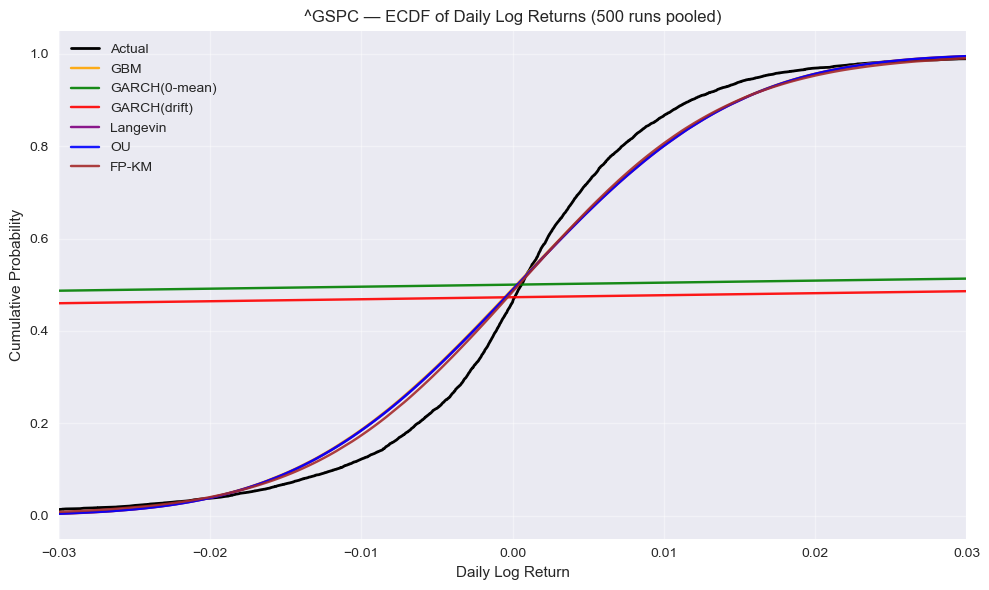


=== ECDF comparison for QQQ (pooled across runs) ===


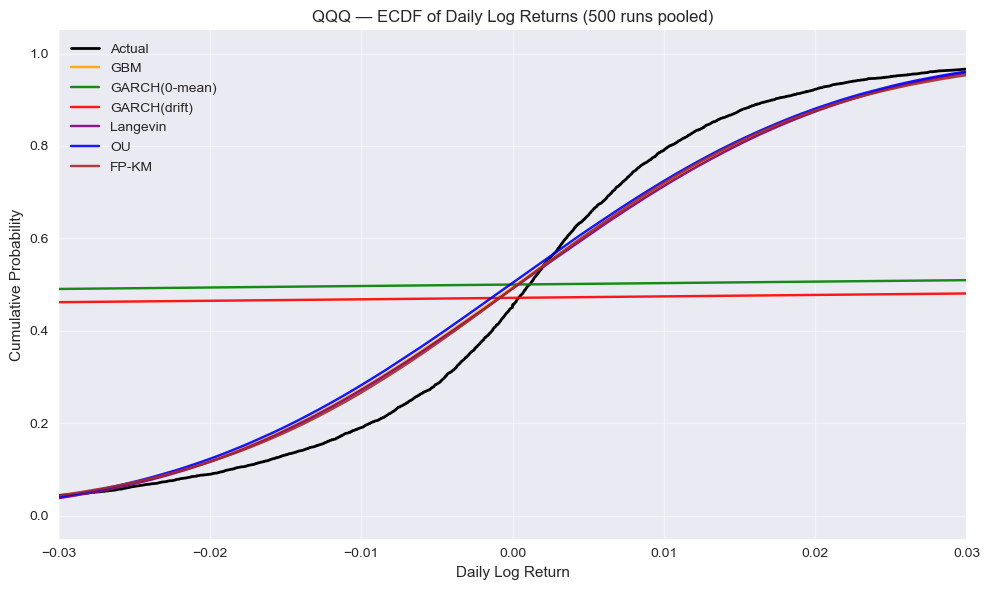


=== ECDF comparison for ^FTSE (pooled across runs) ===


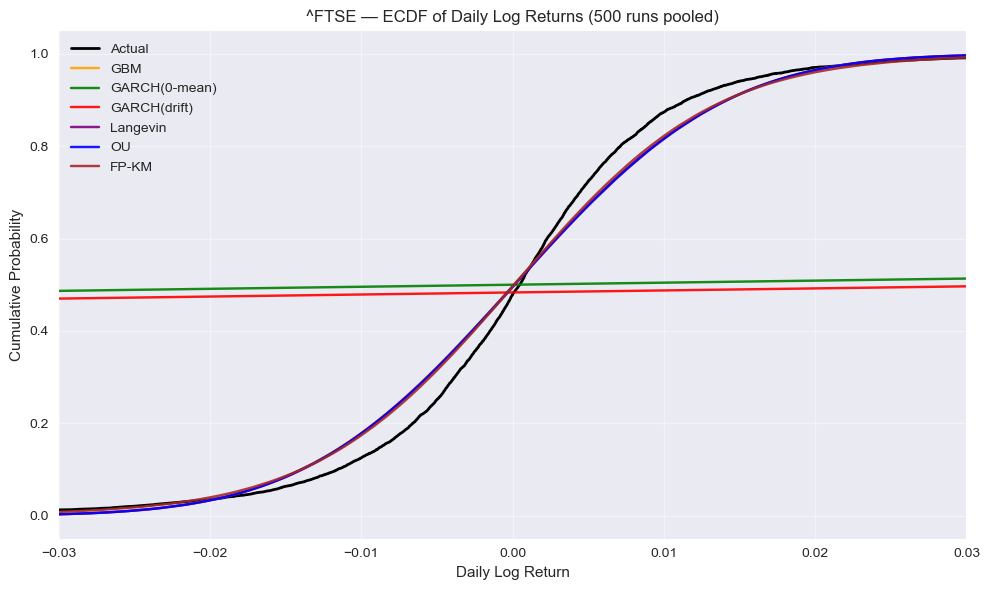


=== ECDF comparison for ^N225 (pooled across runs) ===


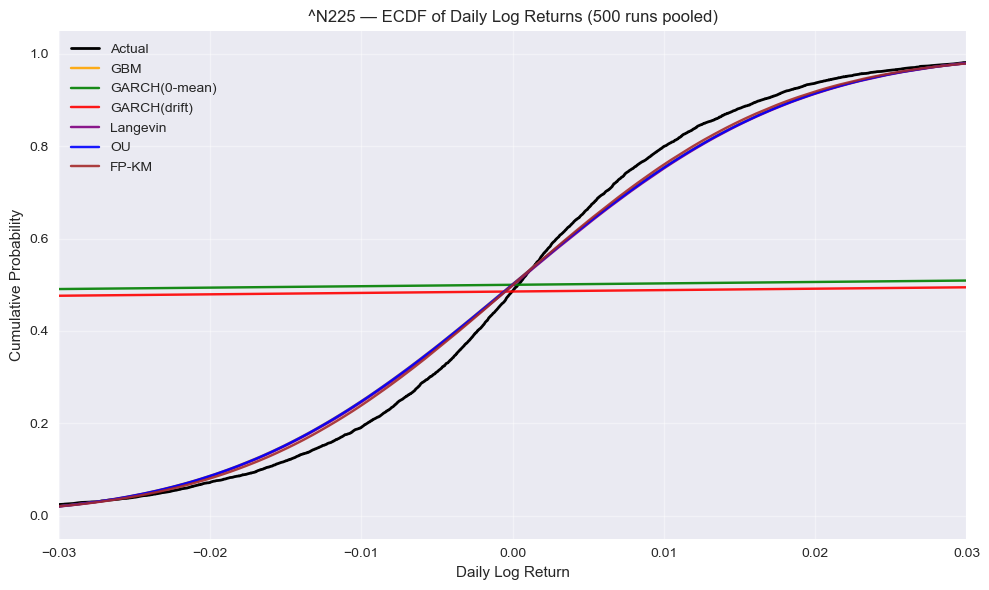


=== ECDF comparison for BTC-USD (pooled across runs) ===


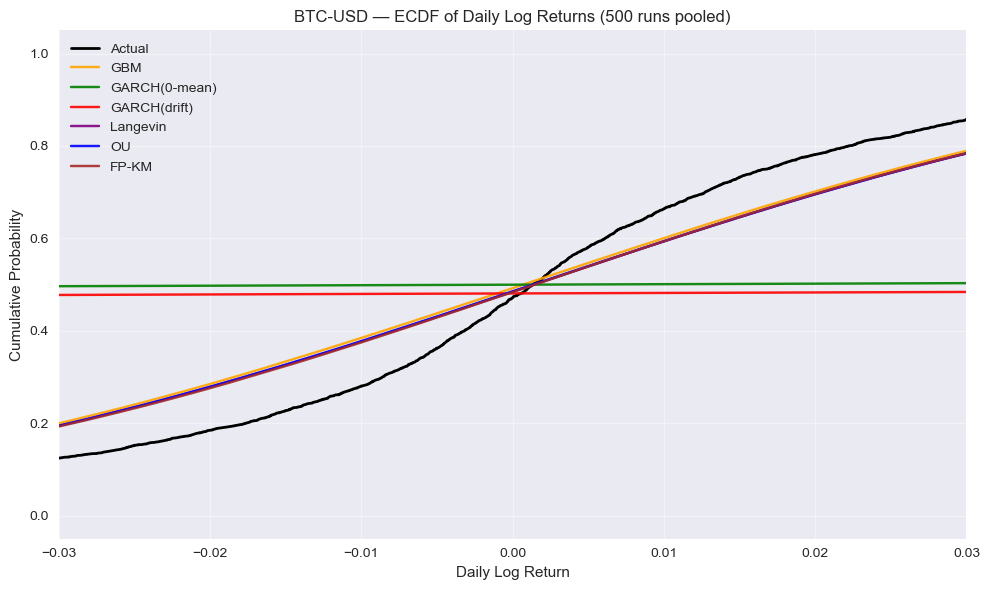

In [19]:
# =========================================
# Cell 10 (fixed): ECDFs (All Models) — Pooled Across Runs
# =========================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model_colors = {
    "GBM": "orange",
    "GARCH(0-mean)": "green",
    "GARCH(drift)": "red",
    "Langevin": "purple",
    "OU": "blue",
    "FP-KM": "brown"
}

def ecdf(data):
    """Compute empirical CDF of 1-D array-like data."""
    x = np.sort(np.asarray(data))
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

for t in rets.keys():
    print(f"\n=== ECDF comparison for {t} (pooled across runs) ===")

    # Actual returns
    actual_returns = rets[t].dropna()

    plt.figure(figsize=(10, 6))

    # Plot actual ECDF
    xa, ya = ecdf(actual_returns)
    plt.plot(xa, ya, label="Actual", color="black", linewidth=2)

    # Loop through models and plot pooled ECDF
    runs_dict = sim_returns_runs.get(t, {})
    for model_name, runs_arr in runs_dict.items():
        if runs_arr is None or not isinstance(runs_arr, np.ndarray) or runs_arr.size == 0:
            continue

        # Flatten across all paths
        pooled_returns = runs_arr.flatten()
        pooled_returns = pooled_returns[~np.isnan(pooled_returns)]  # drop NaN

        if len(pooled_returns) < 10:
            continue  # skip if too few data points

        xs, ys = ecdf(pooled_returns)
        plt.plot(xs, ys,
                 label=model_name,
                 color=model_colors.get(model_name, None),
                 alpha=0.9)

    plt.title(f"{t} — ECDF of Daily Log Returns (500 runs pooled)")
    plt.xlabel("Daily Log Return")
    plt.ylabel("Cumulative Probability")
    plt.xlim(-0.03, 0.03)  # focus on -3% to +3%
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()


In [22]:
# =========================================
# Cell 11 (fixed): Model Evaluation Metrics (500 runs aggregated, safe handling)
# =========================================

from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def _as_series_1d(x, name=None):
    """Coerce x to 1-D float Series with unique index and no NaNs."""
    if isinstance(x, pd.Series):
        s = x
    elif isinstance(x, pd.DataFrame):
        s = x.iloc[:, 0]
    else:
        s = pd.Series(x, name=name)
    s = pd.to_numeric(s.squeeze(), errors="coerce").dropna()
    if s.index.duplicated().any():
        s = s.loc[~s.index.duplicated(keep="last")]
    return s

def _rmse_aligned(actual_price, sim_price) -> float:
    """RMSE after aligning actual and simulated price paths.
       Safely handles NaN/inf values."""
    a = _as_series_1d(actual_price, name="actual")
    b = _as_series_1d(sim_price,   name="sim")

    aligned = pd.concat([a.rename("actual"), b.rename("sim")], axis=1, join="inner")
    aligned = aligned.replace([np.inf, -np.inf], np.nan).dropna()

    if aligned.empty:
        return np.nan

    return np.sqrt(mean_squared_error(aligned["actual"].values, aligned["sim"].values))

# --- Evaluation ---
metrics_summary = []

for t in rets.keys():
    actual_price = _as_series_1d(data[t]["Close"])
    actual_returns = _as_series_1d(rets[t])

    for model_name, runs_arr in sim_returns_runs[t].items():
        if runs_arr is None or not isinstance(runs_arr, np.ndarray) or runs_arr.size == 0:
            continue

        n_paths, n_steps = runs_arr.shape
        run_metrics = []

        for i in range(n_paths):
            sim_ret = runs_arr[i, :]
            sim_ret = pd.Series(sim_ret, index=actual_returns.index[:len(sim_ret)])

            # --- RMSE on price paths (if available) ---
            rmse = np.nan
            price_runs = sim_prices_runs.get(t, {}).get(model_name)
            if isinstance(price_runs, np.ndarray) and price_runs.shape[0] == n_paths:
                sim_price = pd.Series(
                    price_runs[i, :],
                    index=(actual_price.index[:price_runs.shape[1]])
                )
                rmse = _rmse_aligned(actual_price, sim_price)

            # --- KS-test & Wasserstein on returns ---
            ks_stat, ks_p, w_dist = np.nan, np.nan, np.nan
            if len(actual_returns) > 5 and len(sim_ret.dropna()) > 5:
                ks_stat, ks_p = ks_2samp(actual_returns.values, sim_ret.dropna().values)
                w_dist = wasserstein_distance(actual_returns.values, sim_ret.dropna().values)

            run_metrics.append([rmse, ks_stat, ks_p, w_dist])

        run_metrics = np.array(run_metrics, dtype=float)

        # --- Aggregate statistics ---
        rmse_mean, rmse_sd = np.nanmean(run_metrics[:,0]), np.nanstd(run_metrics[:,0])
        ks_mean, ks_sd = np.nanmean(run_metrics[:,1]), np.nanstd(run_metrics[:,1])
        w_mean,  w_sd  = np.nanmean(run_metrics[:,3]), np.nanstd(run_metrics[:,3])

        metrics_summary.append({
            "Ticker": t,
            "Model": model_name,
            "RMSE_mean": rmse_mean,
            "RMSE_sd": rmse_sd,
            "KS_mean": ks_mean,
            "KS_sd": ks_sd,
            "Wasserstein_mean": w_mean,
            "Wasserstein_sd": w_sd,
            "n_paths": n_paths
        })

# --- Results table ---
metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df.sort_values(by=["Ticker", "RMSE_mean", "Wasserstein_mean"], na_position="last")

pd.set_option('display.float_format', '{:.6f}'.format)
print("=== Aggregated Model Evaluation Metrics (mean ± SD across runs) ===")
display(metrics_df)

# Optionally save to file
metrics_df.to_csv("model_evaluation_metrics_ensemble.csv", index=False)


=== Aggregated Model Evaluation Metrics (mean ± SD across runs) ===


Ticker          Model                                          RMSE_mean  \
24  BTC-USD            GBM                                       38867.656478   
28  BTC-USD             OU                                      124579.975100   
27  BTC-USD       Langevin                                      262130.415671   
29  BTC-USD          FP-KM                                      431845.755673   
25  BTC-USD  GARCH(0-mean)                                                inf   
26  BTC-USD   GARCH(drift)                                                inf   
10      QQQ             OU                                         152.218009   
6       QQQ            GBM                                         230.847907   
11      QQQ          FP-KM                                         437.907939   
9       QQQ       Langevin                                         447.974038   
7       QQQ  GARCH(0-mean)                                                inf   
8       QQQ   GARCH(drift)                                                inf   
16    ^FTSE             OU                                        1697.367956   
12    ^FTSE            GBM                                        3662.837495   
17    ^FTSE          FP-KM                                        4776.317146   
15    ^FTSE       Langevin                                        5272.365757   
13    ^FTSE  GARCH(0-mean) 29042435458795910870561320778919130074536378469...   
14    ^FTSE   GARCH(drift)                                                inf   
0     ^GSPC            GBM                                        1760.820515   
4     ^GSPC             OU                                        2103.666807   
3     ^GSPC       Langevin                                        2353.511560   
5     ^GSPC          FP-KM                                        8327.783865   
1     ^GSPC  GARCH(0-mean) 62848458051289803861703020761973358453358492530...   
2     ^GSPC   GARCH(drift)                                                inf   
22    ^N225             OU                                       11998.914215   
18    ^N225            GBM                                       26821.729140   
21    ^N225       Langevin                                       45633.136743   
23    ^N225          FP-KM                                       47079.687594   
19    ^N225  GARCH(0-mean)                                                inf   
20    ^N225   GARCH(drift)                                                inf   

                                              RMSE_sd  KS_mean    KS_sd  \
24                                       74016.617023 0.111095 0.007502   
28                                      391894.482400 0.104635 0.005608   
27                                     1462294.389148 0.104738 0.006071   
29                                     2006502.440217 0.102630 0.006808   
25                                                NaN 0.488347 0.004961   
26                                                NaN 0.502289 0.007993   
10                                          23.607505 0.106087 0.006139   
6                                          351.234425 0.097021 0.006037   
11                                         906.619649 0.090304 0.006051   
9                                          954.518923 0.094929 0.005171   
7                                                 NaN 0.481338 0.004022   
8                                                 NaN 0.505562 0.006109   
16                                         448.017552 0.073330 0.003252   
12                                        2796.291756 0.075001 0.004313   
17                                        5697.458851 0.067719 0.005014   
15                                        6938.149574 0.073103 0.004005   
13 63532574355773701186731114668945928232533710643... 0.483641 0.003626   
14                                                NaN 0.496709 0.005377   
0                                         1900.719660 0.094865 0.004


=== Entropy comparison for ^GSPC ===


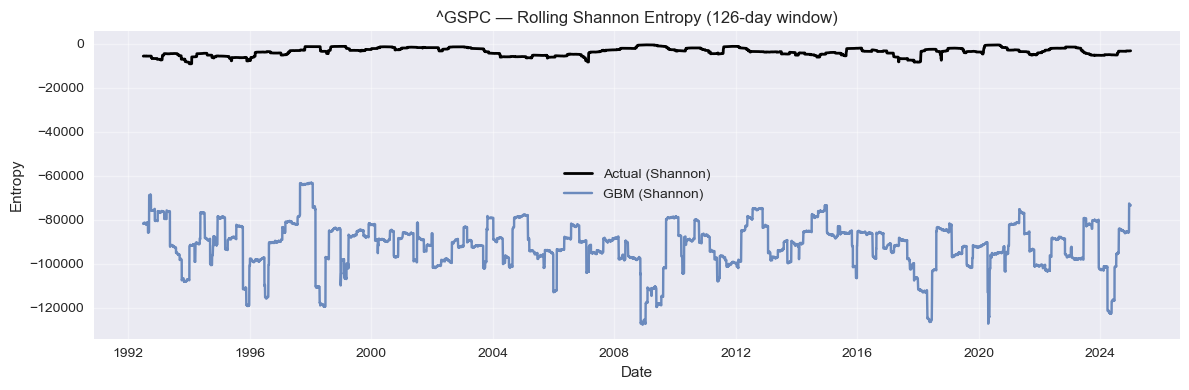

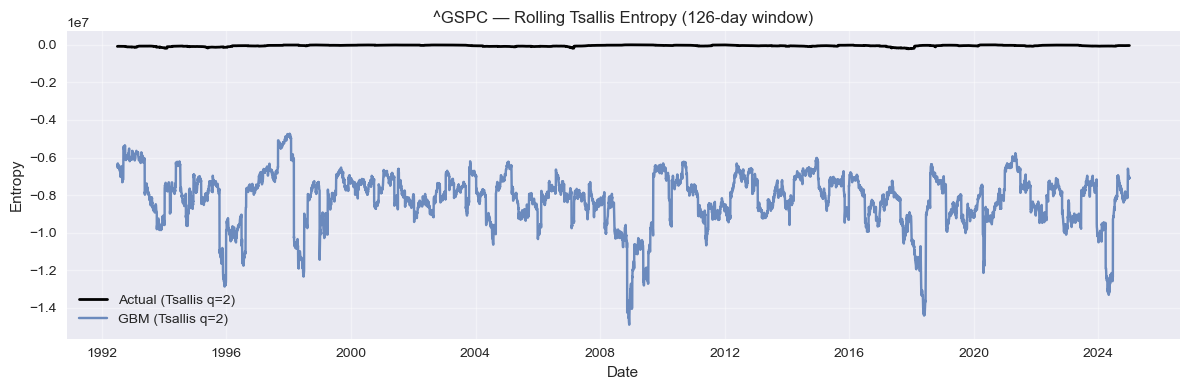

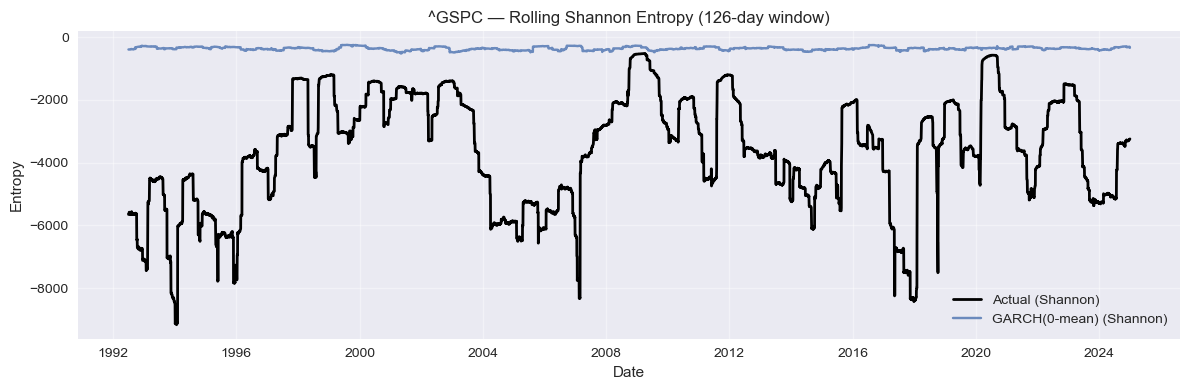

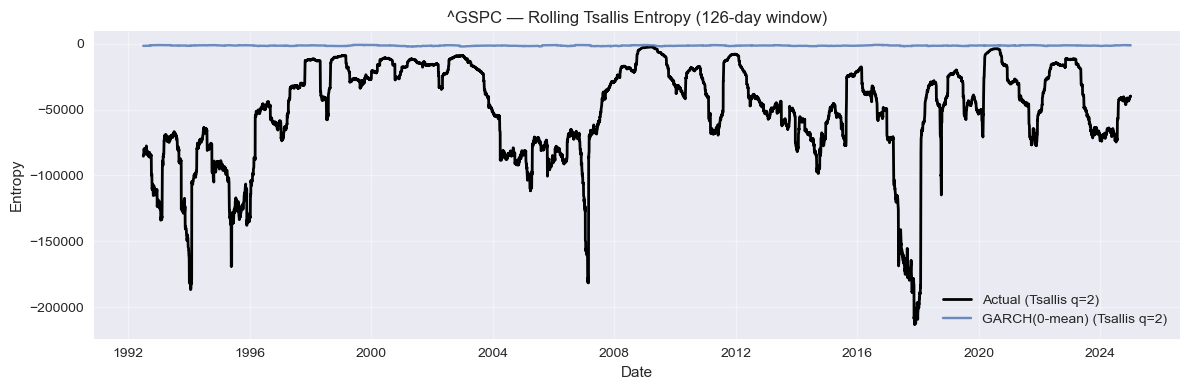

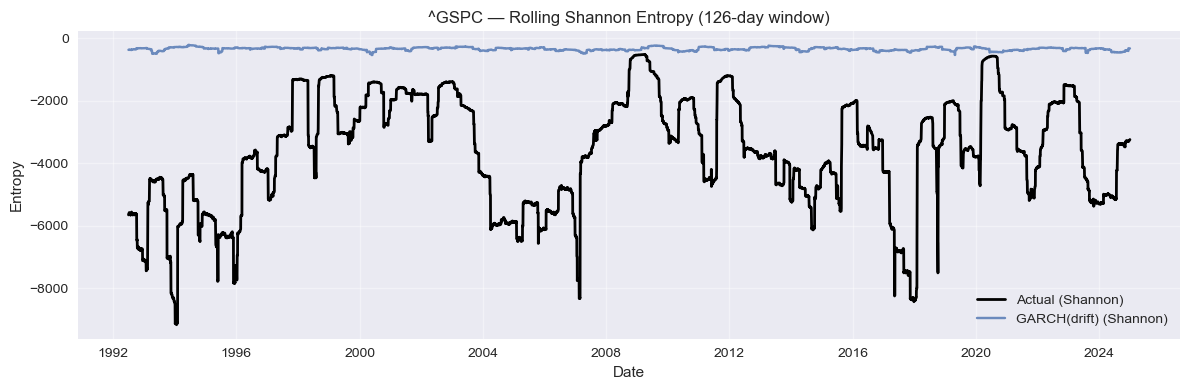

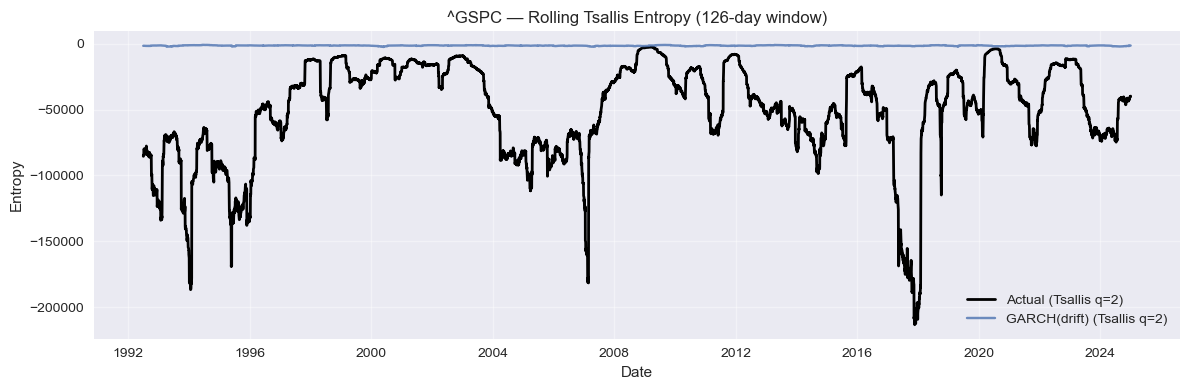

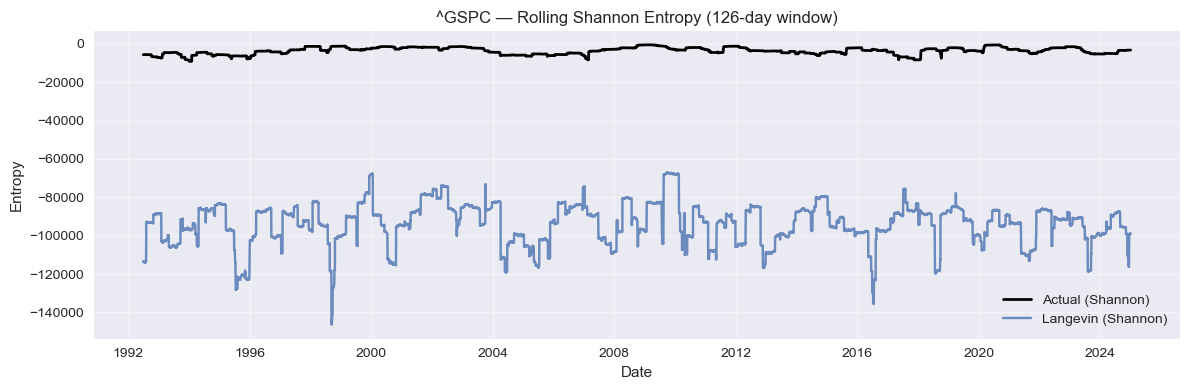

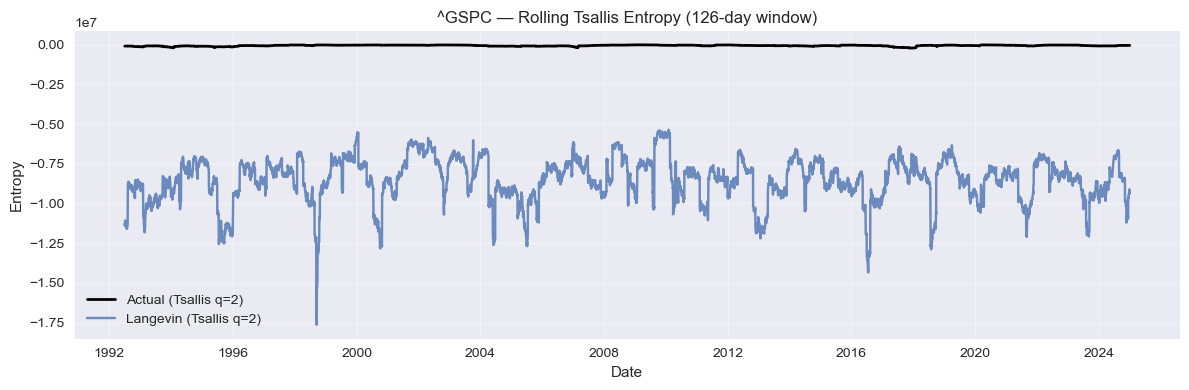

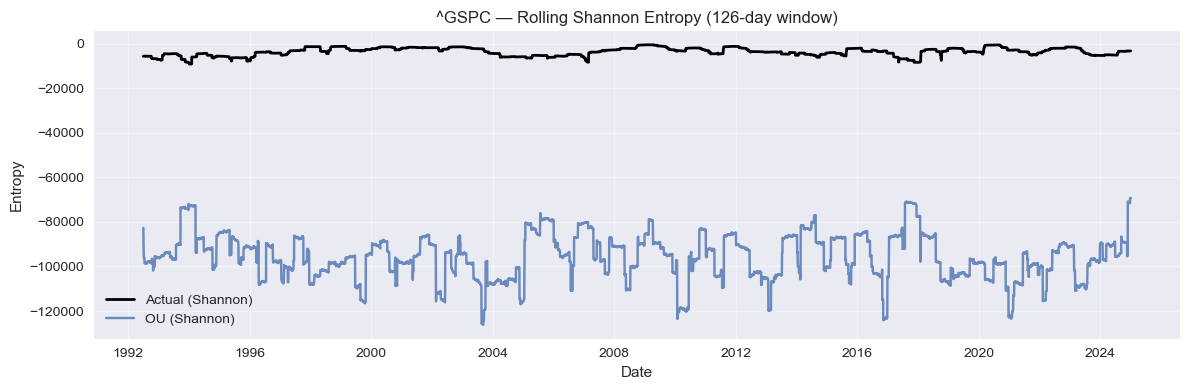

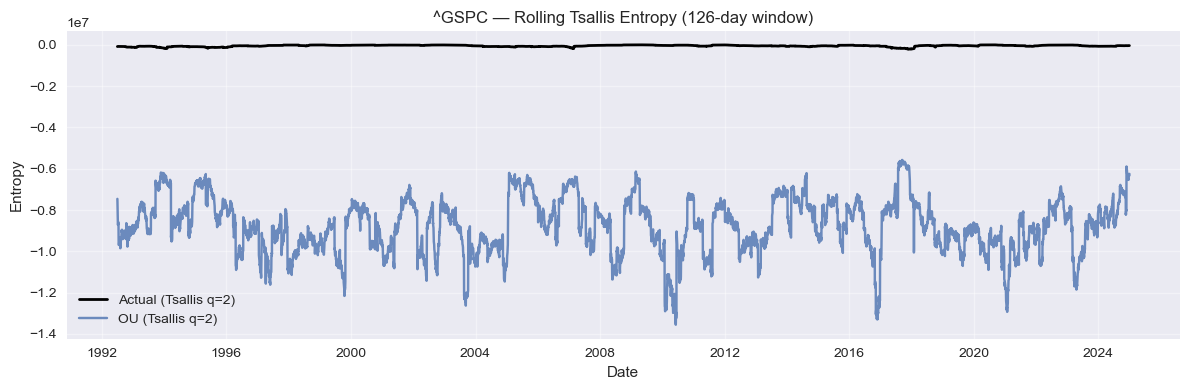

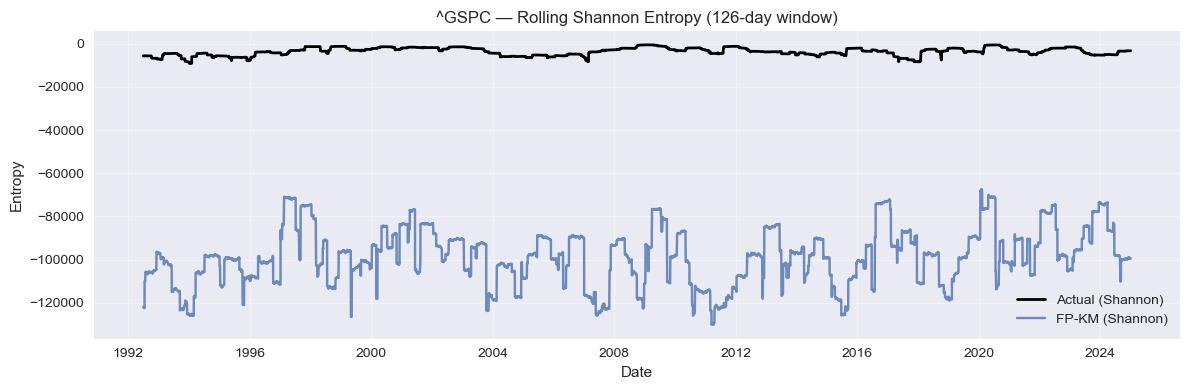

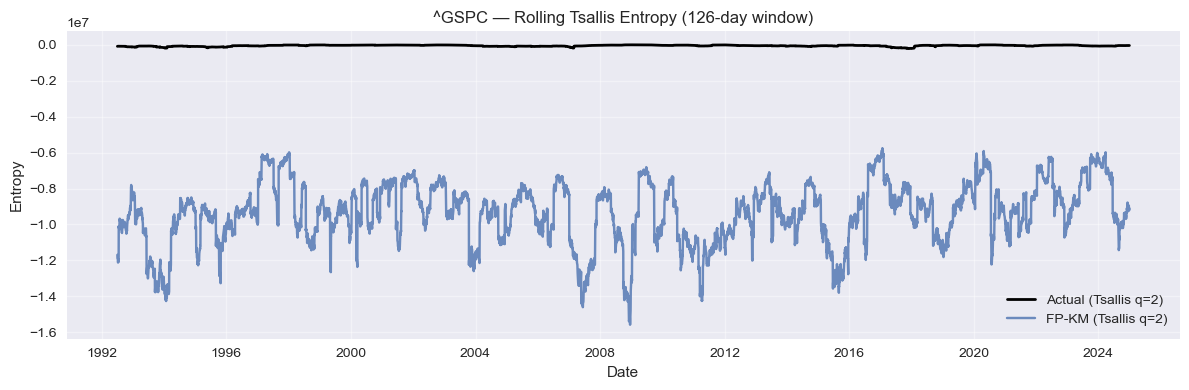


=== Entropy comparison for QQQ ===


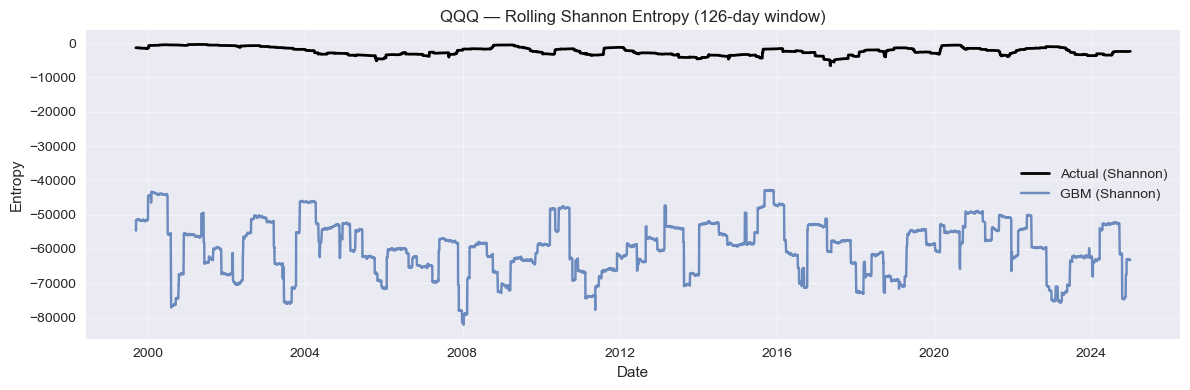

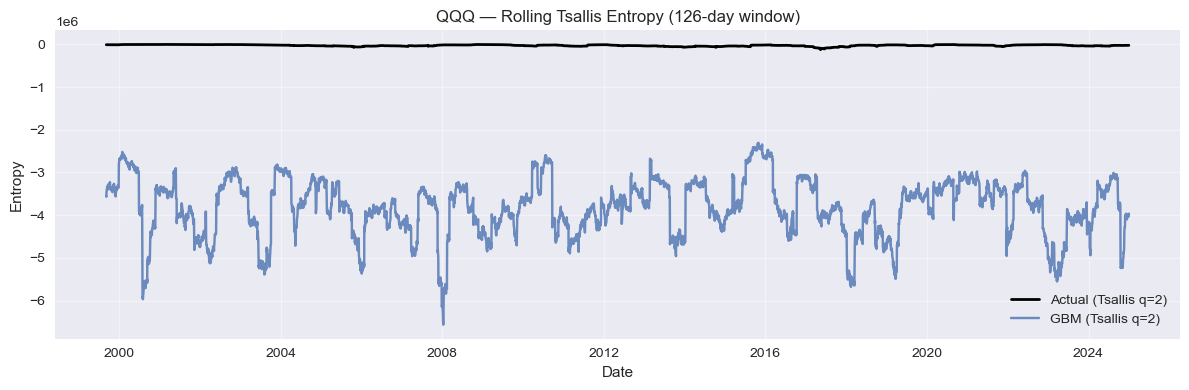

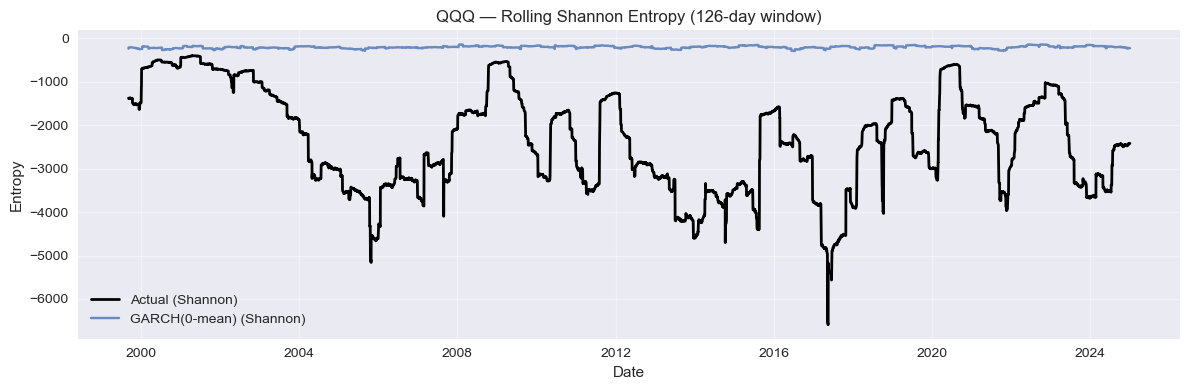

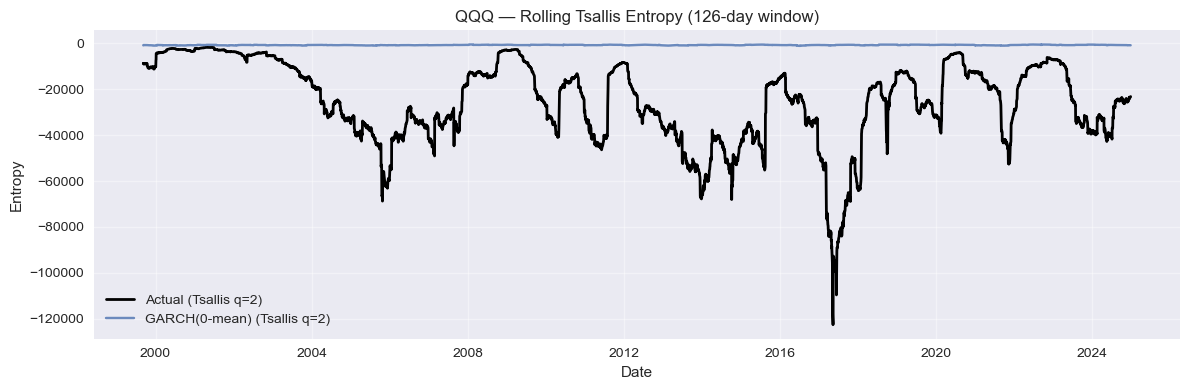

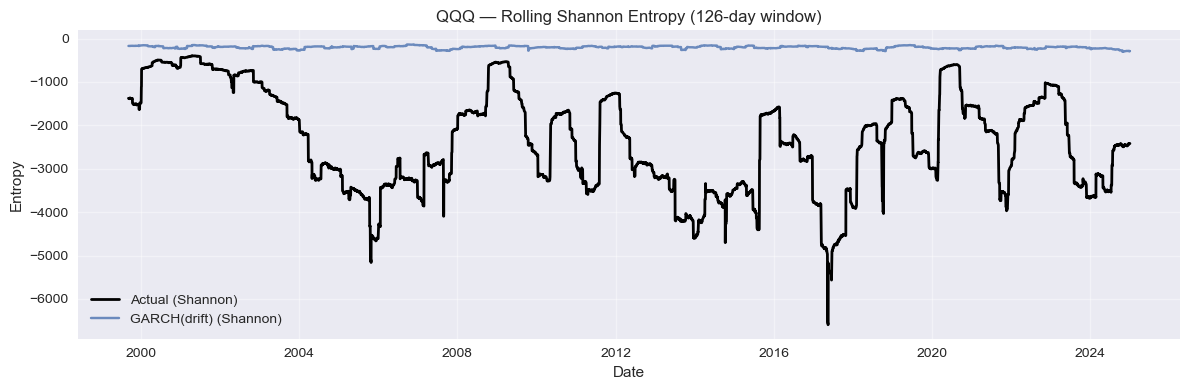

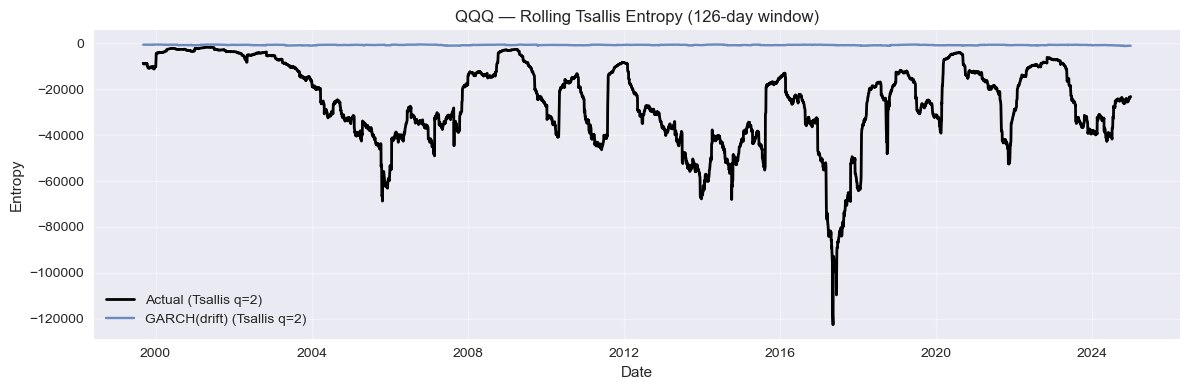

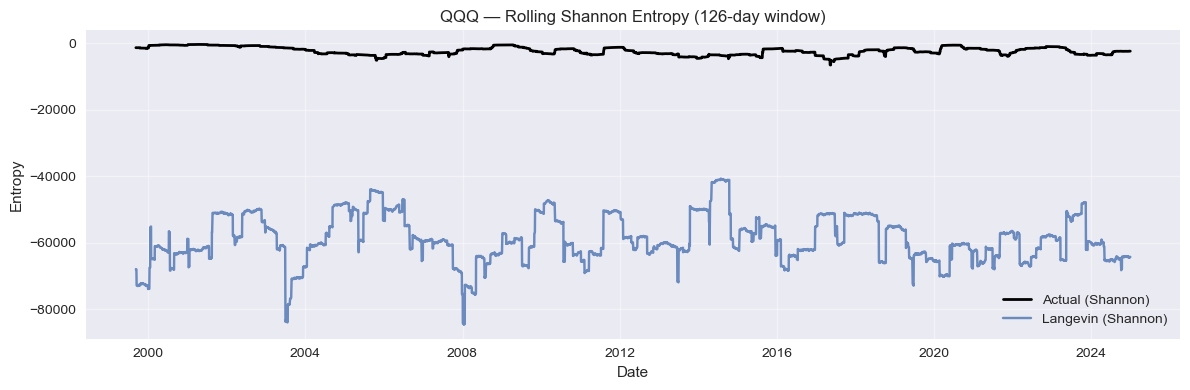

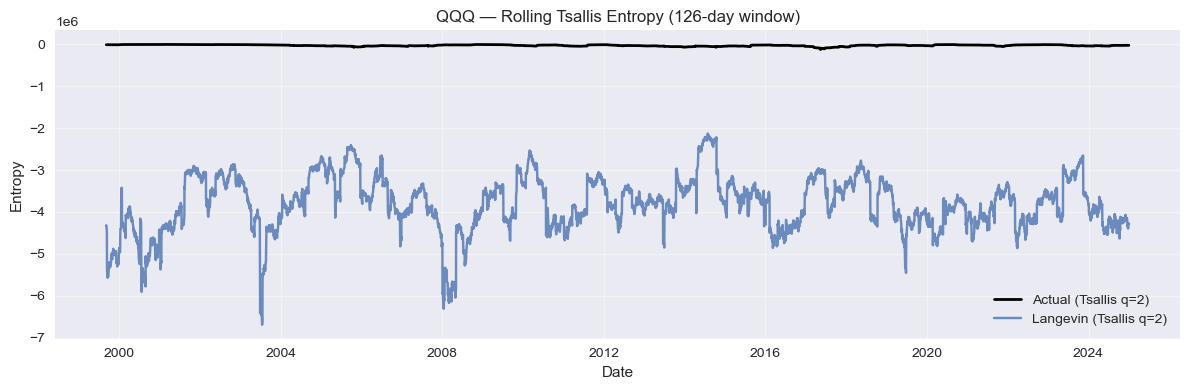

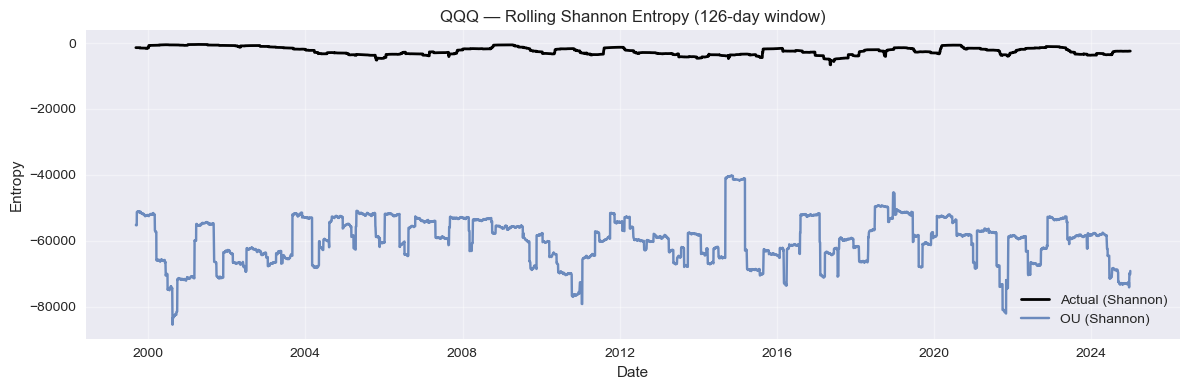

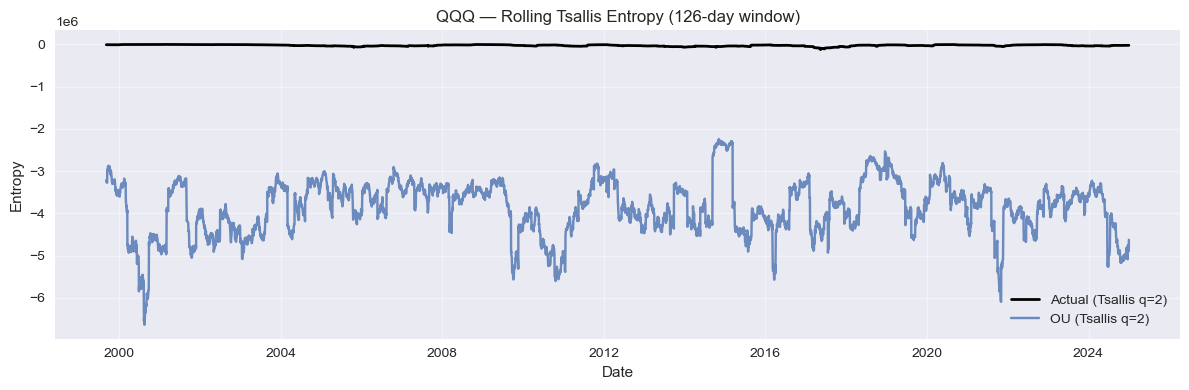

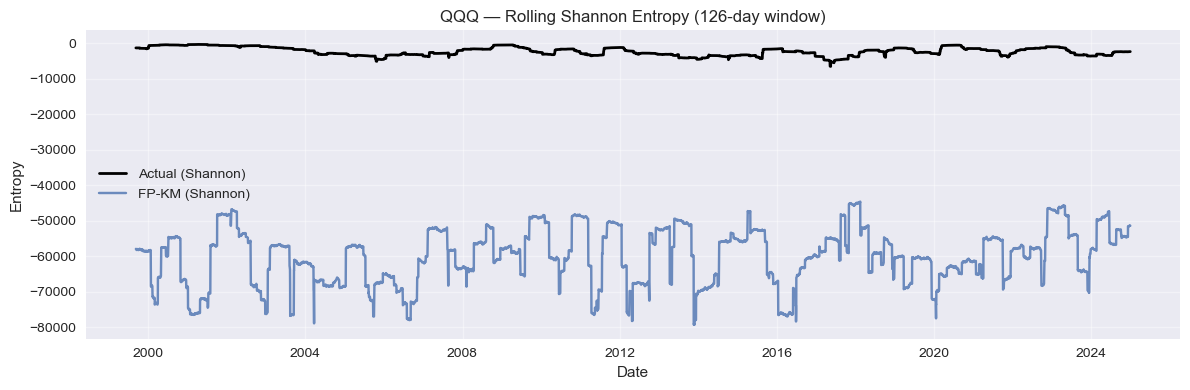

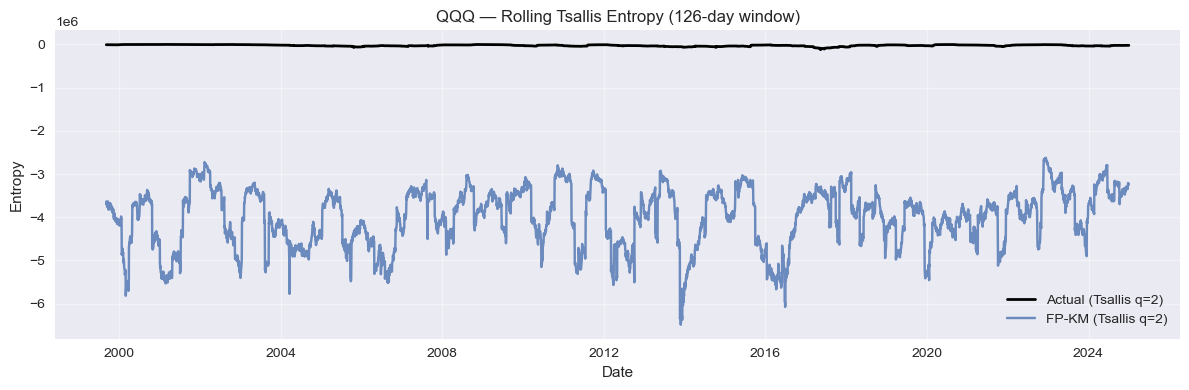


=== Entropy comparison for ^FTSE ===


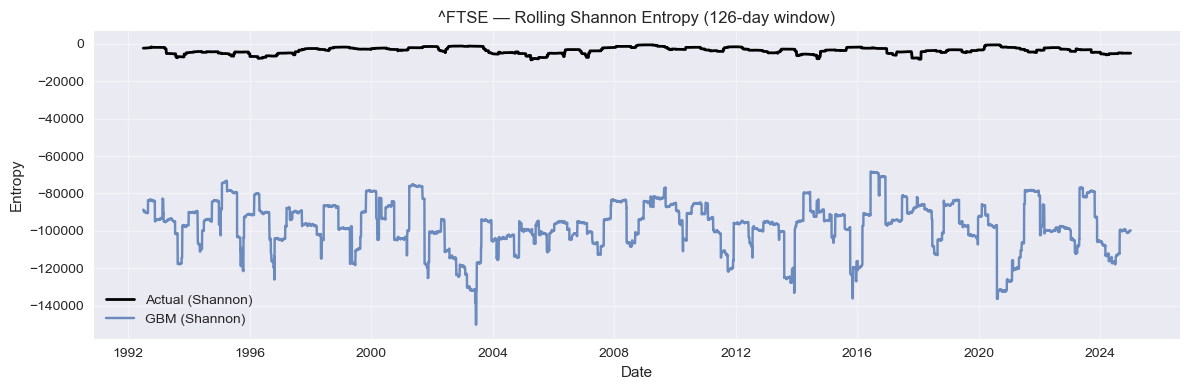

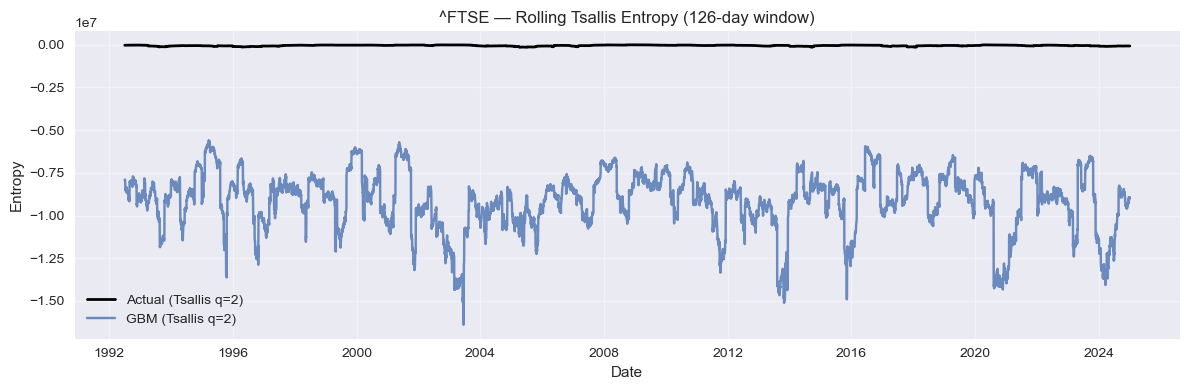

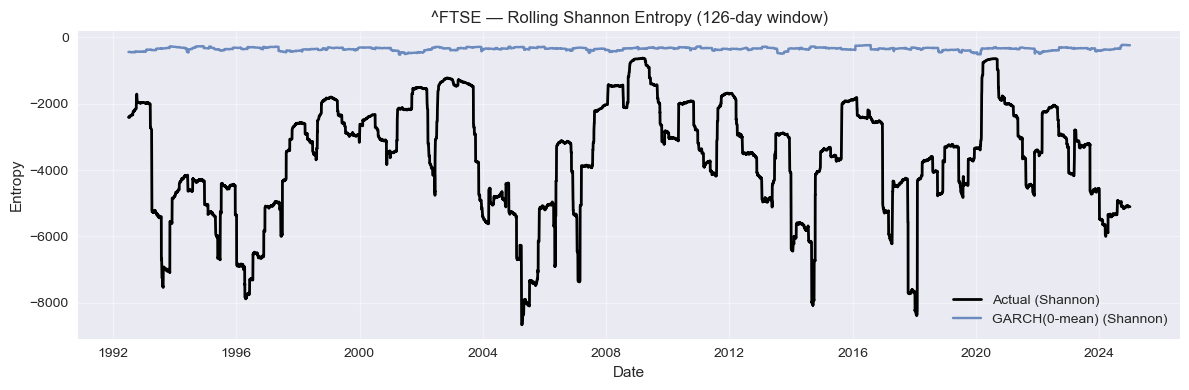

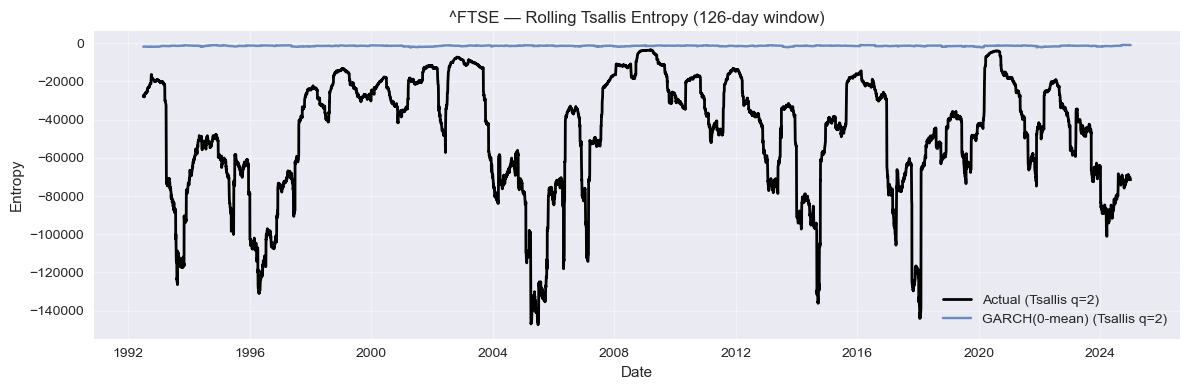

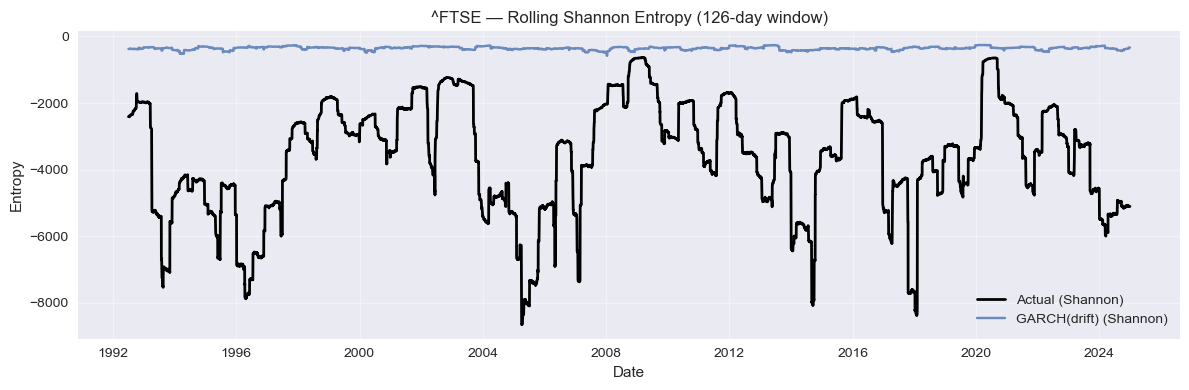

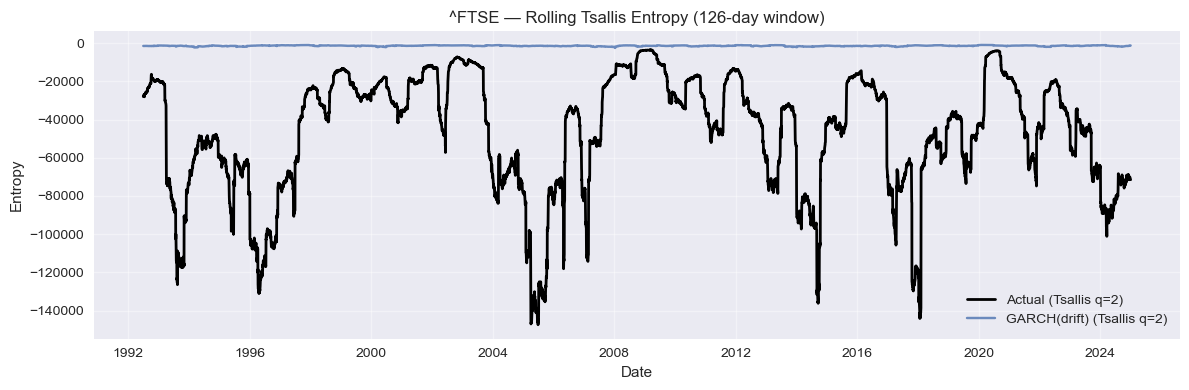

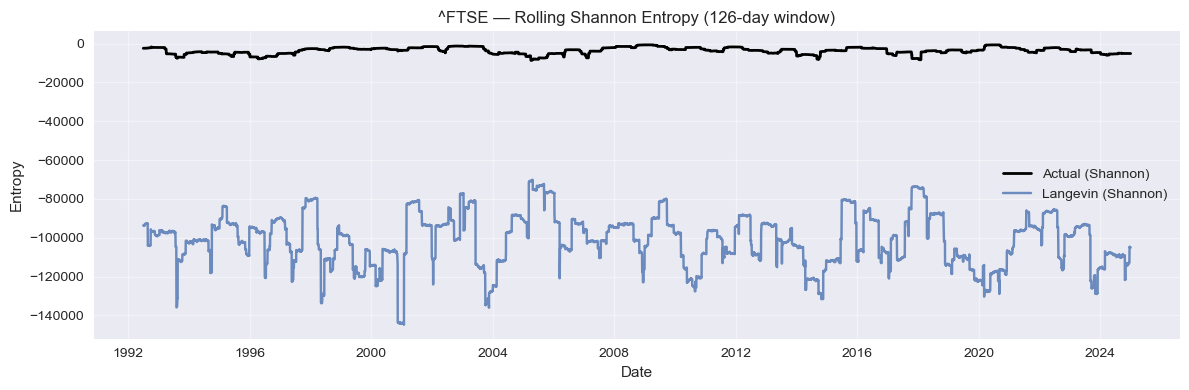

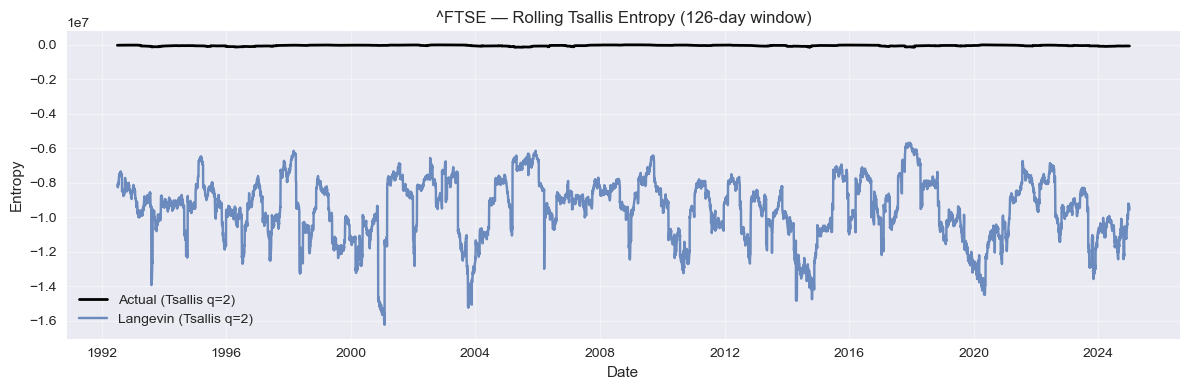

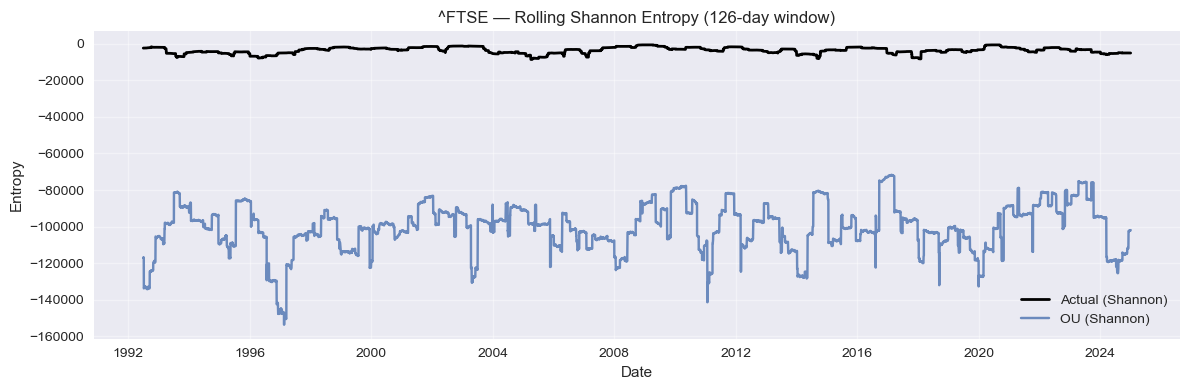

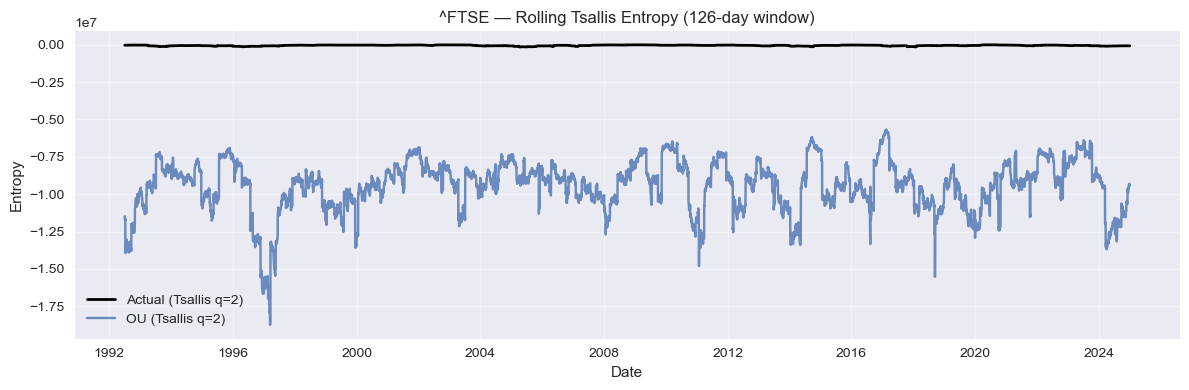

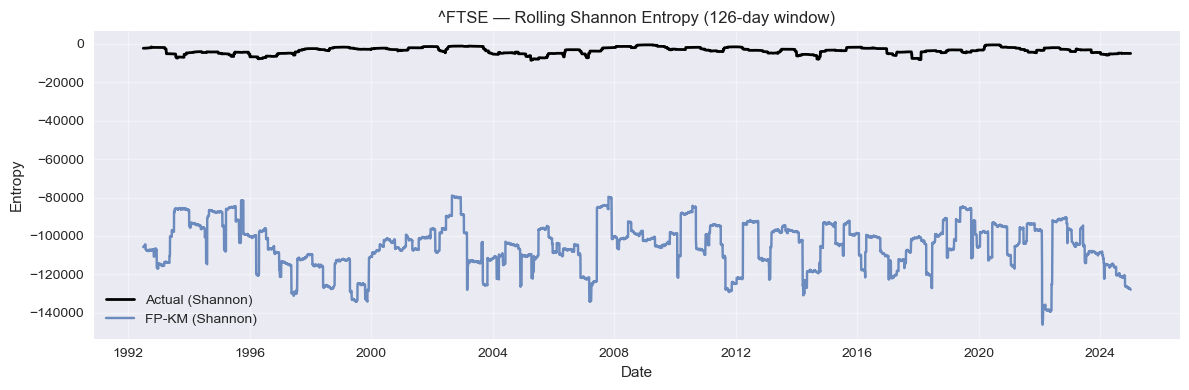

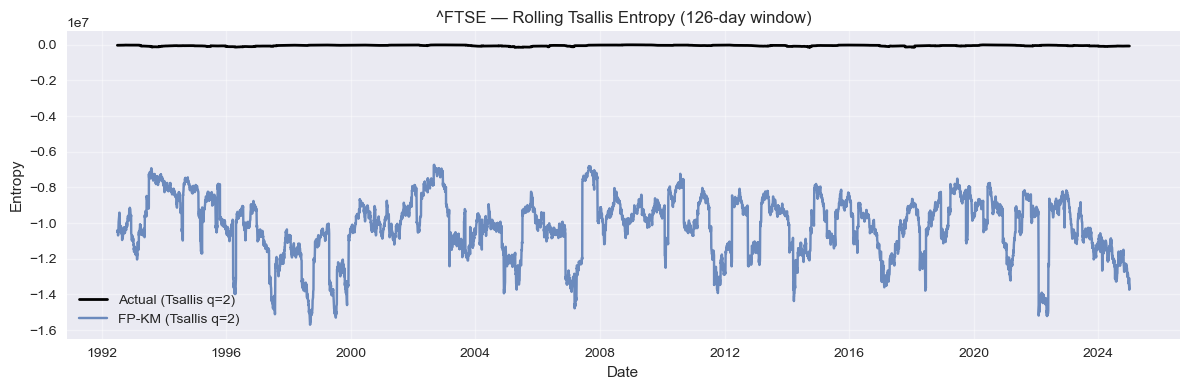


=== Entropy comparison for ^N225 ===


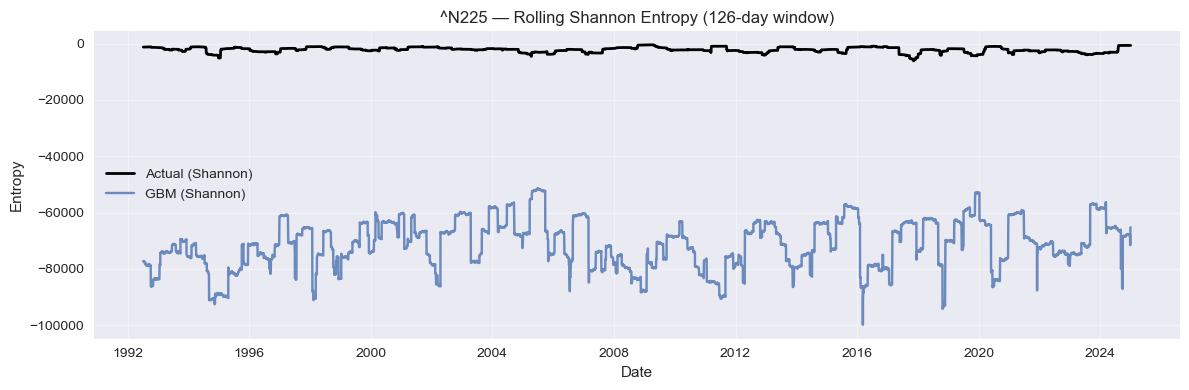

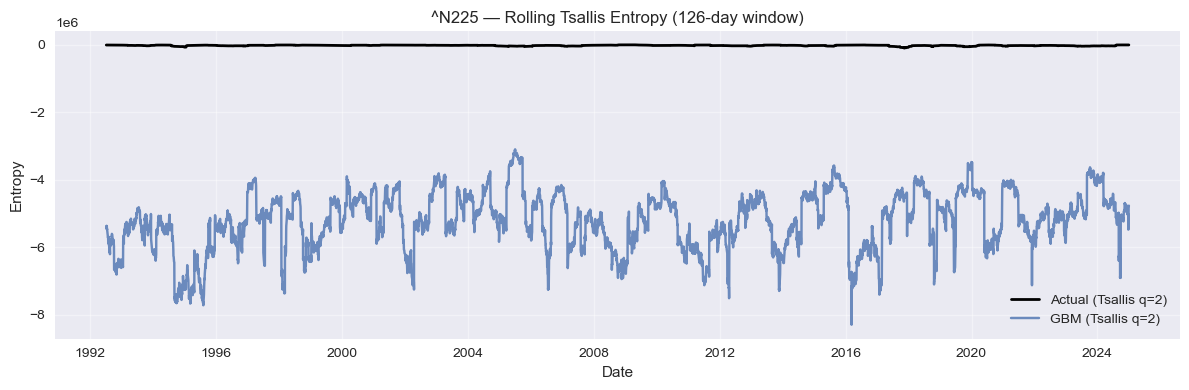

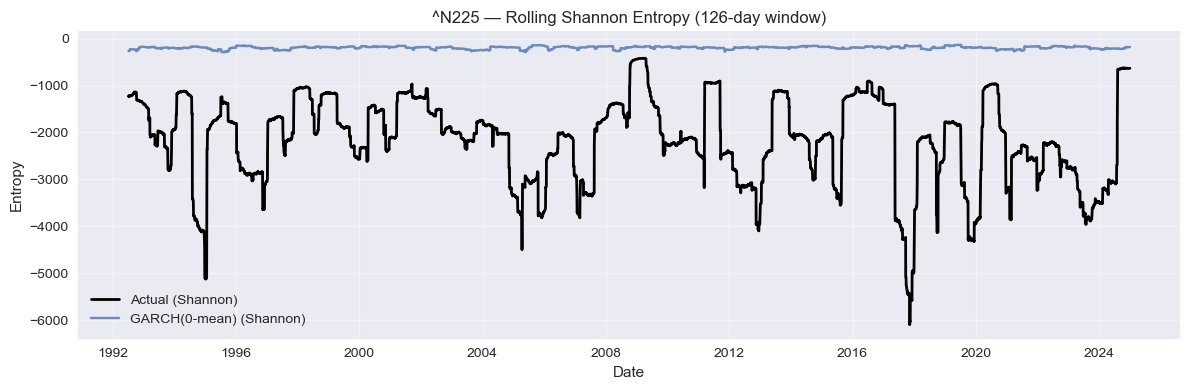

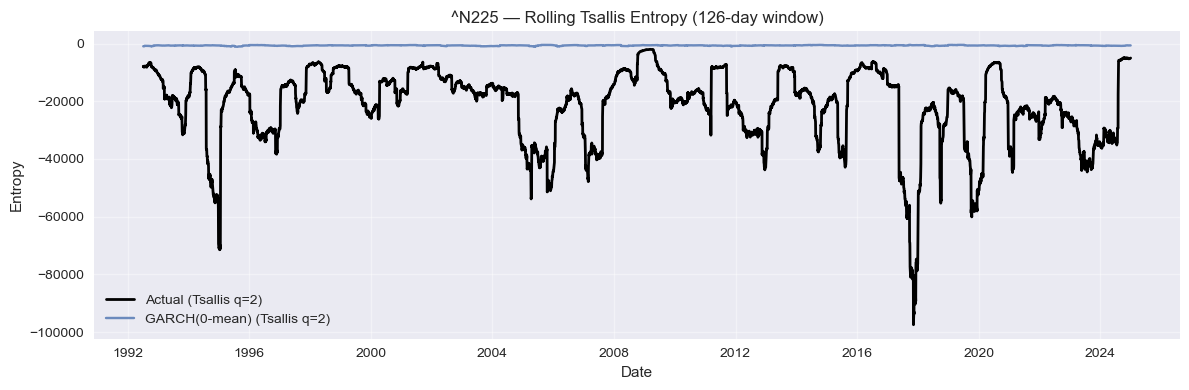

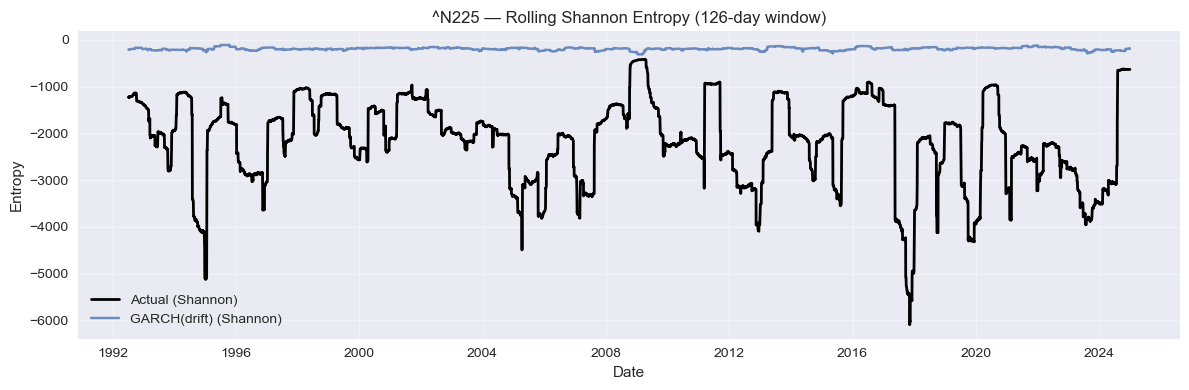

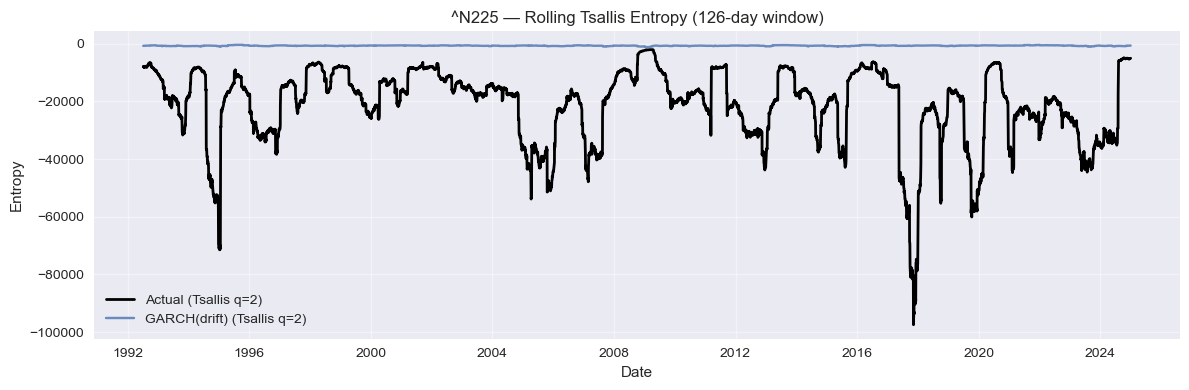

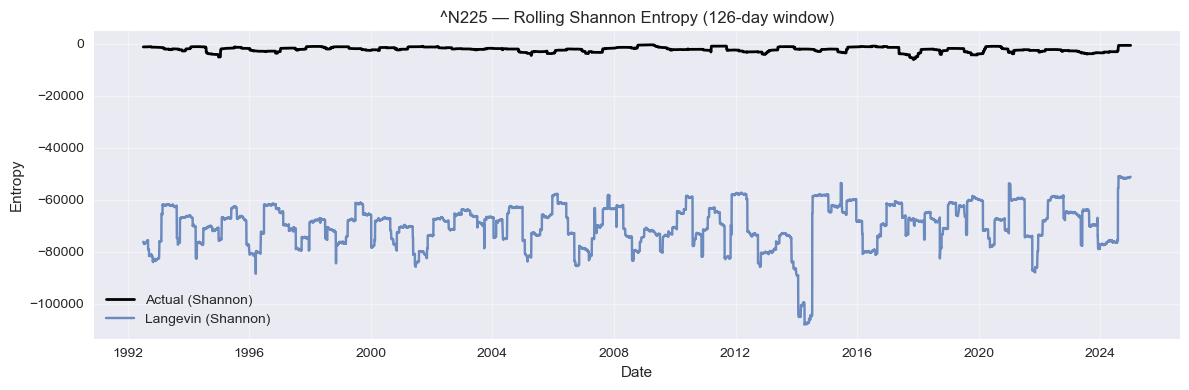

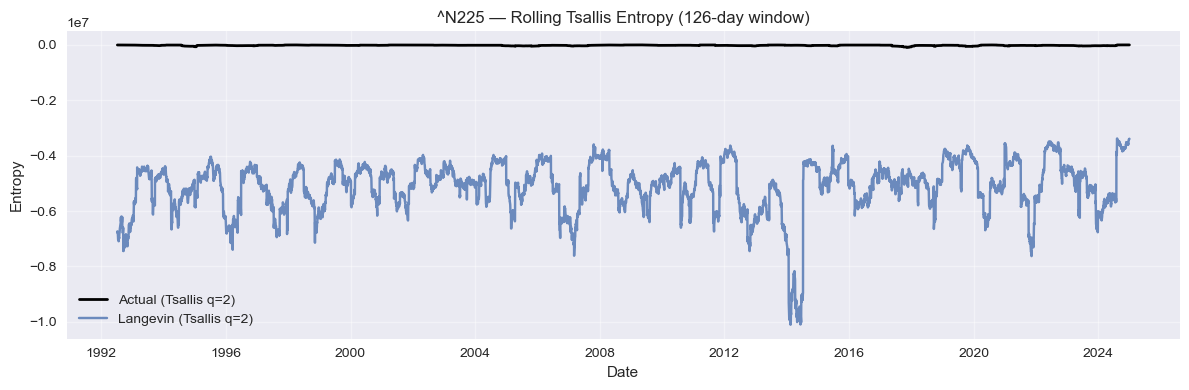

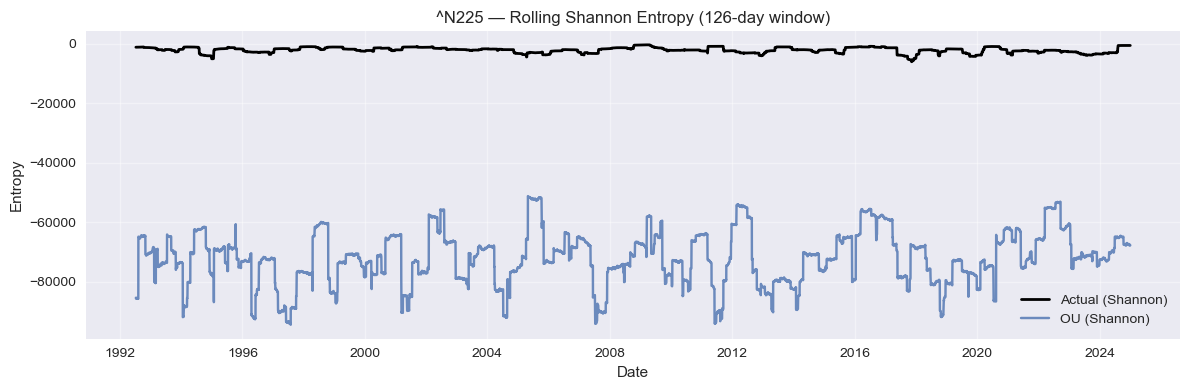

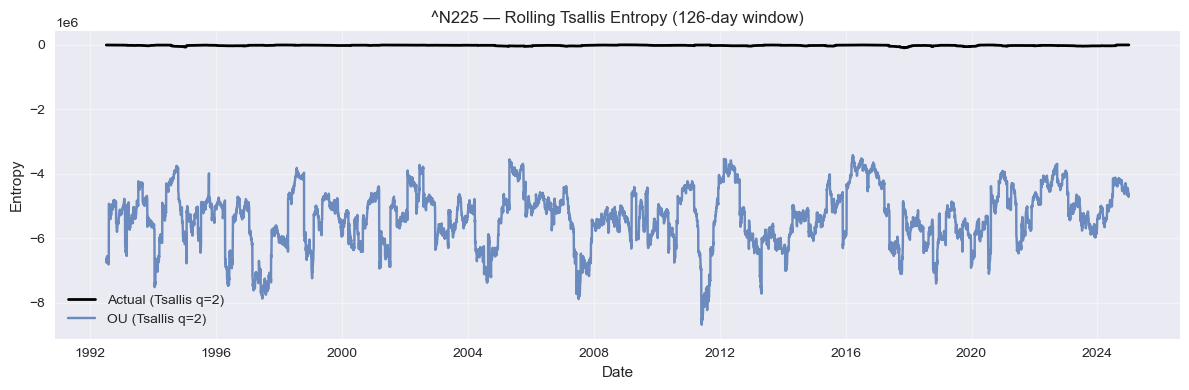

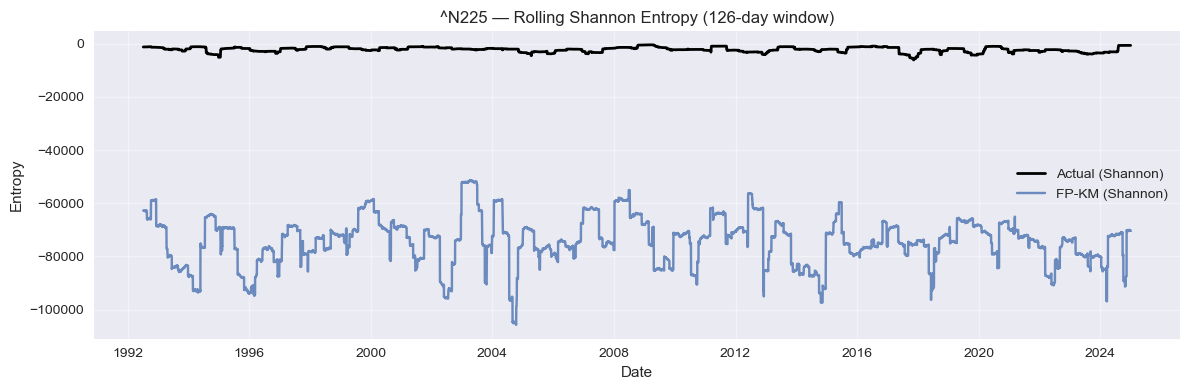

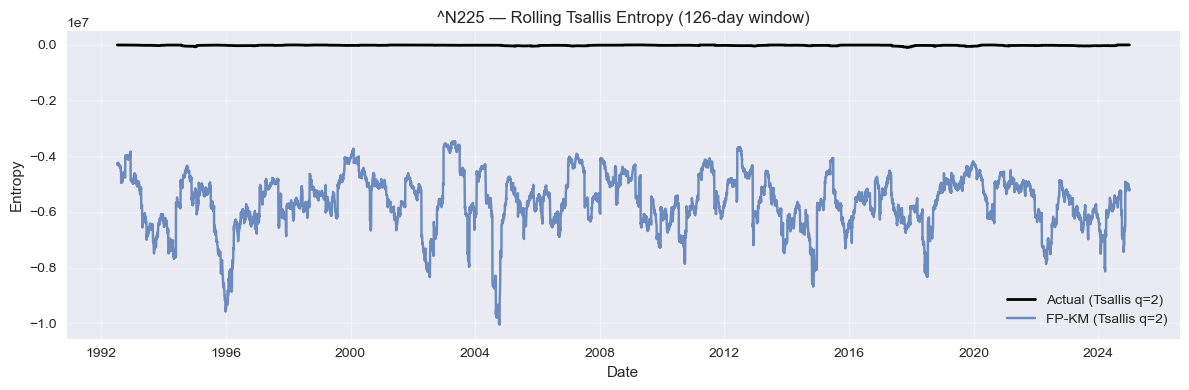


=== Entropy comparison for BTC-USD ===


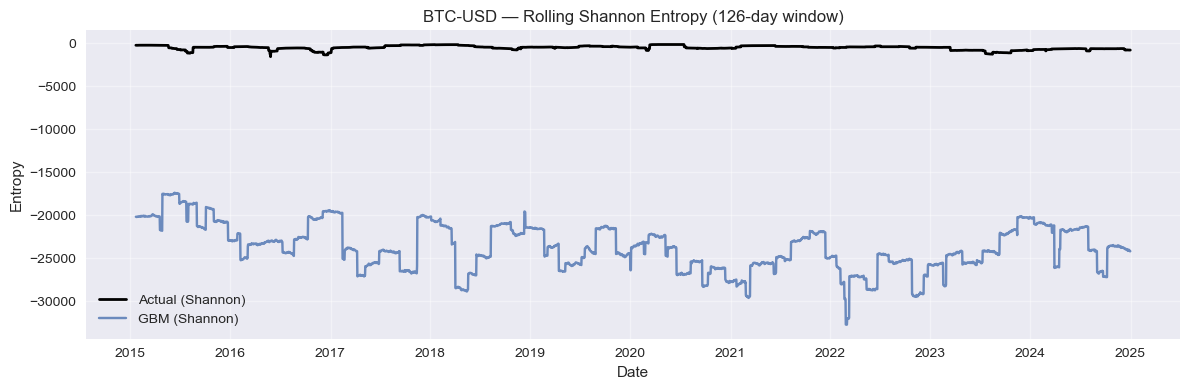

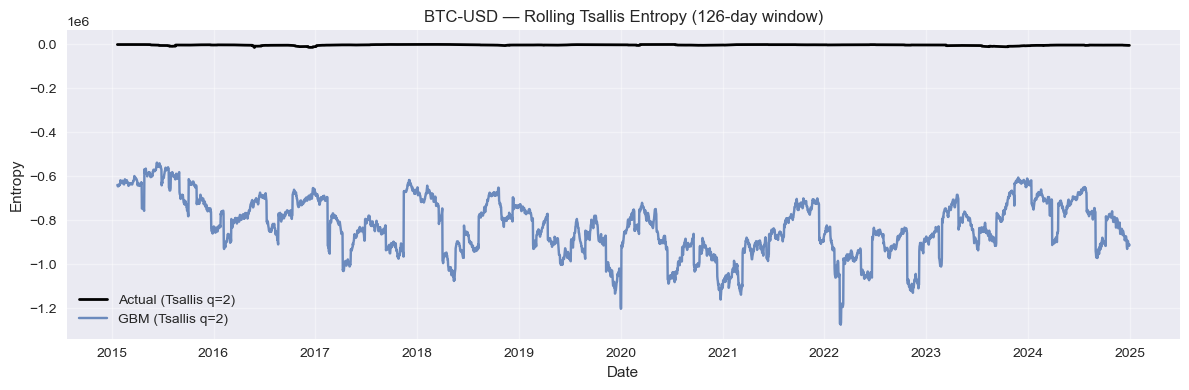

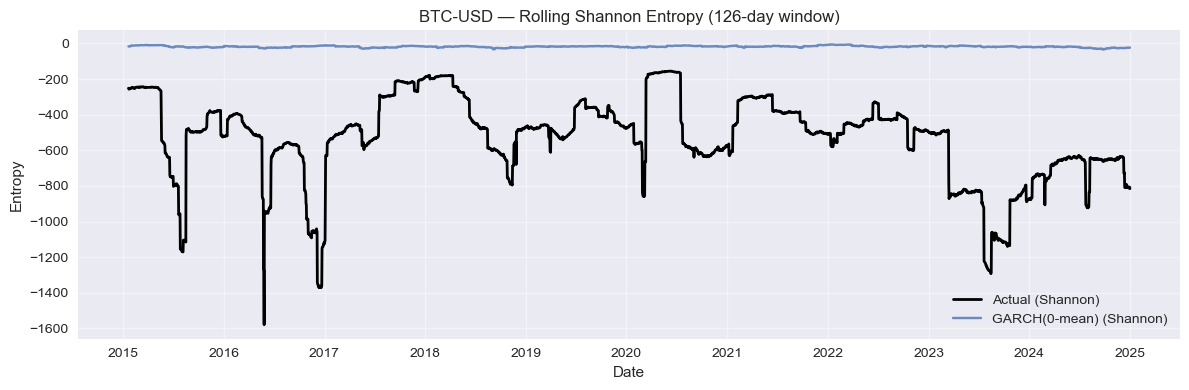

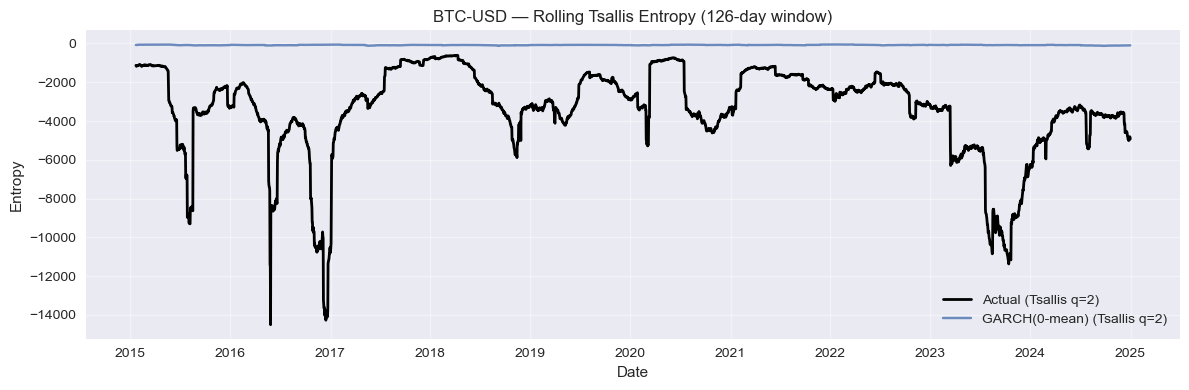

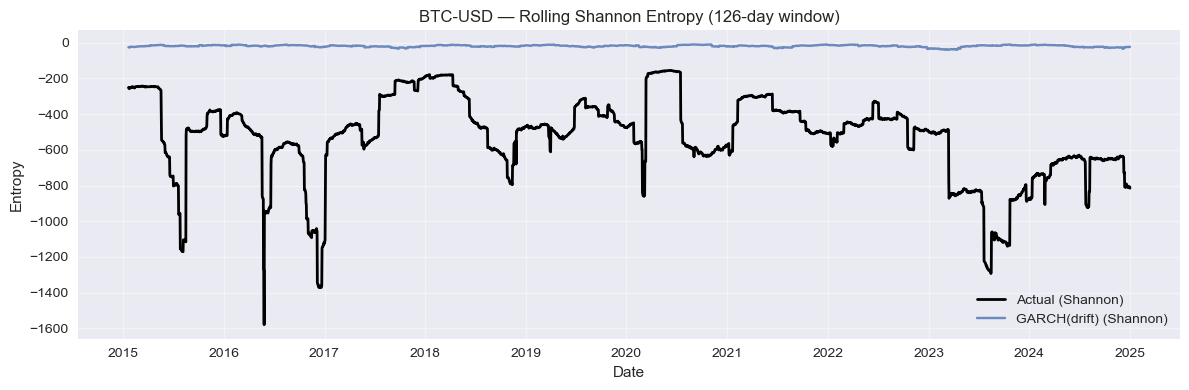

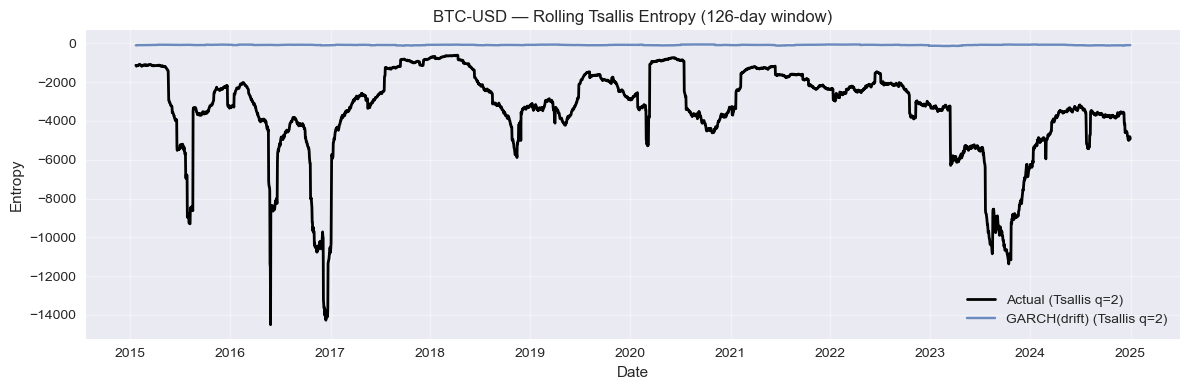

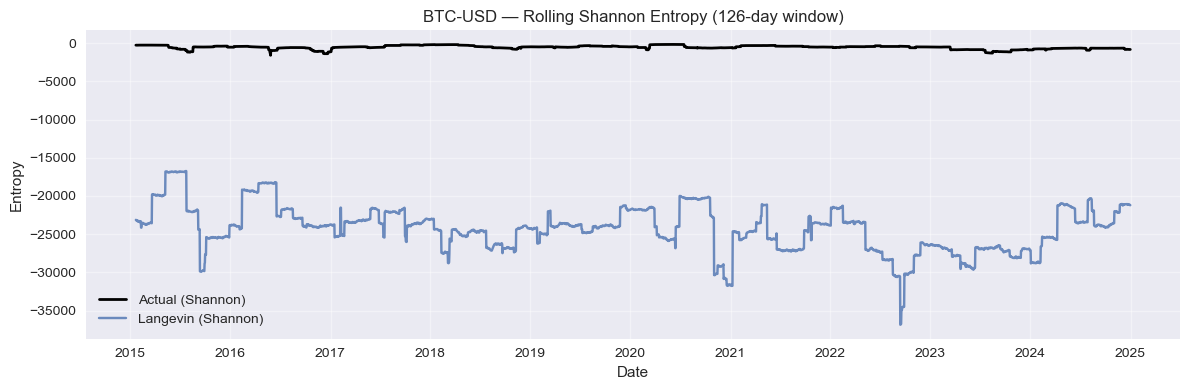

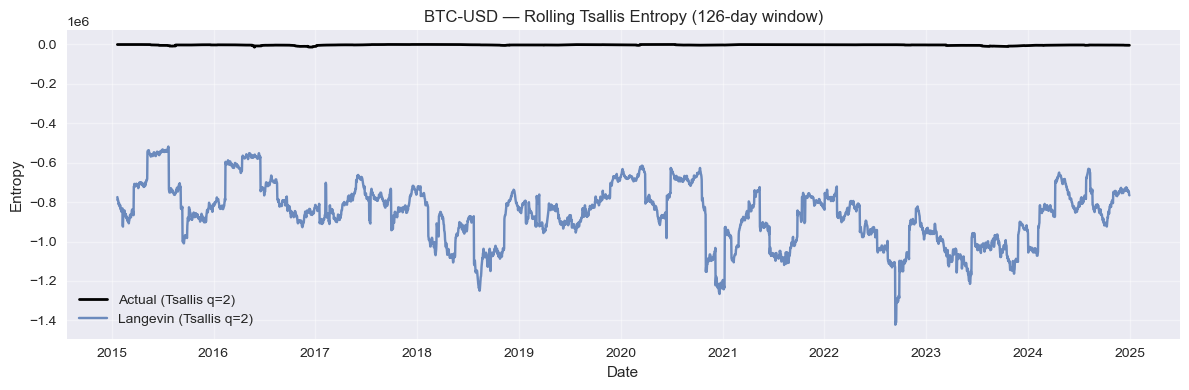

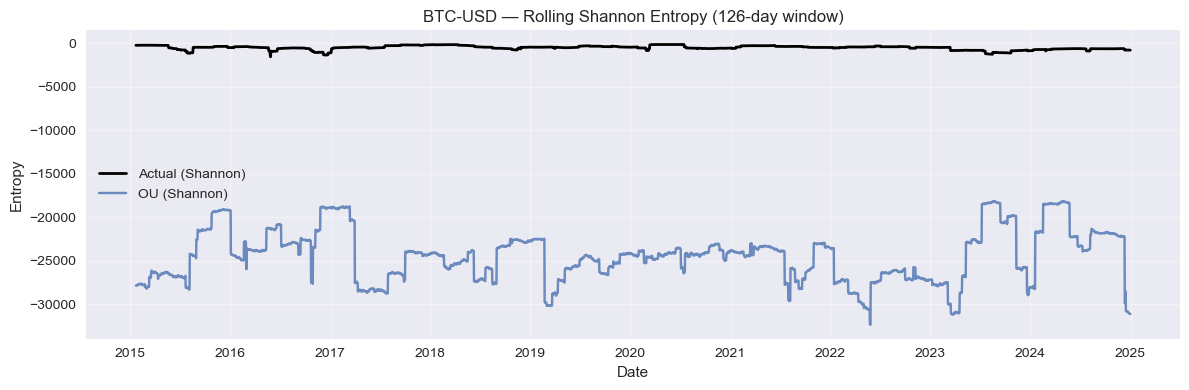

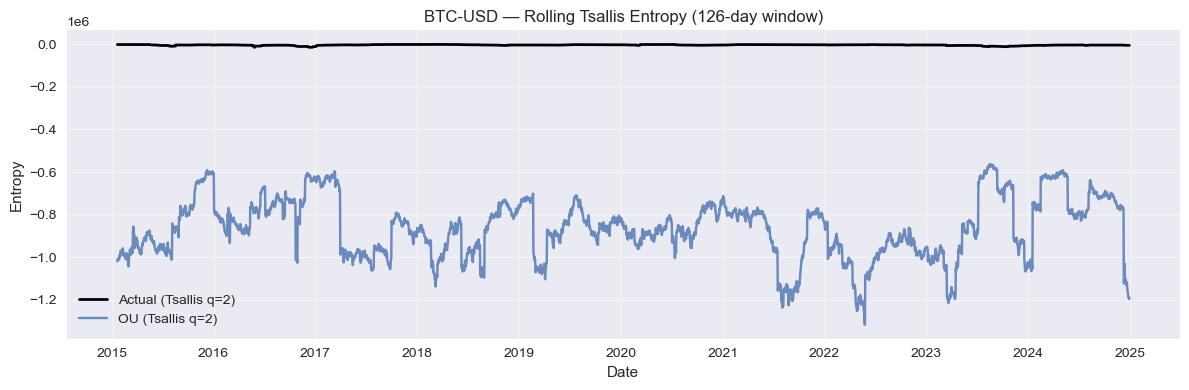

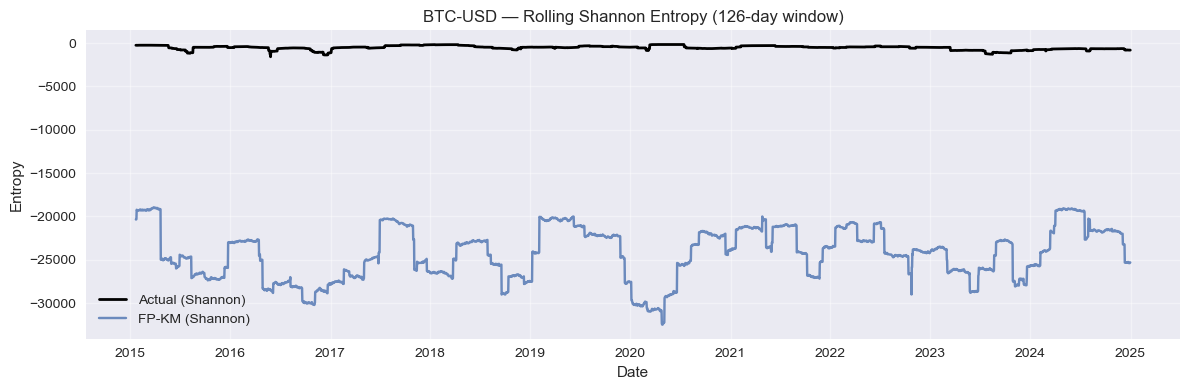

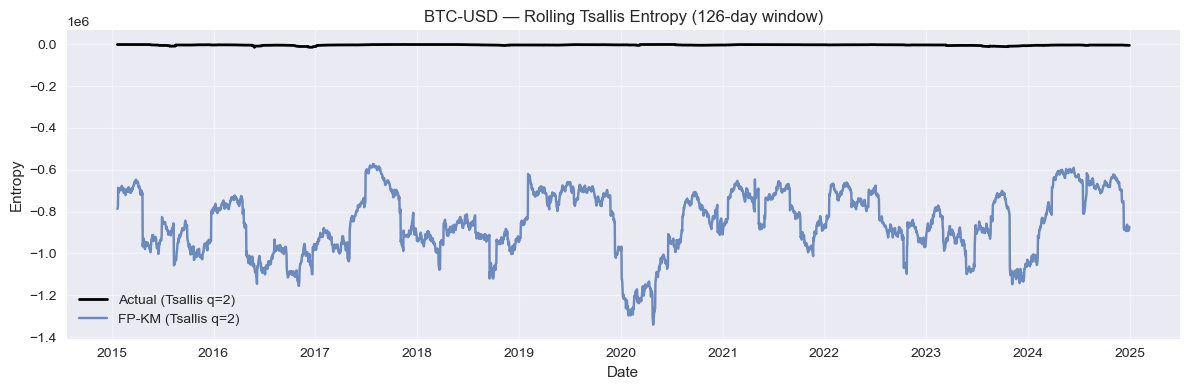


=== Entropy Evaluation Metrics (RMSE of Shannon & Tsallis) ===


Ticker          Model  Shannon_RMSE    Tsallis_RMSE
0     ^GSPC            GBM  88697.724470  8292221.983066
1     ^GSPC  GARCH(0-mean)   3728.387532    62137.169253
2     ^GSPC   GARCH(drift)   3743.001716    62175.171542
3     ^GSPC       Langevin  90756.021341  8576244.448274
4     ^GSPC             OU  92584.712641  8822213.584254
5     ^GSPC          FP-KM  95995.185507  9466280.552153
6       QQQ            GBM  57735.386751  3851233.581823
7       QQQ  GARCH(0-mean)   2448.069626    30631.492548
8       QQQ   GARCH(drift)   2446.902435    30626.548974
9       QQQ       Langevin  56996.159808  3849713.849888
10      QQQ             OU  57899.500241  3895245.227618
11      QQQ          FP-KM  58208.052482  4028043.665095
12    ^FTSE            GBM  94425.377982  9251817.574137
13    ^FTSE  GARCH(0-mean)   3676.175648    55126.492285
14    ^FTSE   GARCH(drift)   3668.355927    55075.272558
15    ^FTSE       Langevin  98398.687417  9646254.518771
16    ^FTSE             OU  97764.070405  9544094.723452
17    ^FTSE          FP-KM 101989.688945 10255654.228877
18    ^N225            GBM  69607.409485  5266870.379820
19    ^N225  GARCH(0-mean)   2170.317796    24445.444438
20    ^N225   GARCH(drift)   2169.633080    24442.498610
21    ^N225       Langevin  68204.911309  5197766.298123
22    ^N225             OU  70365.803245  5401363.533724
23    ^N225          FP-KM  72503.950792  5711820.589580
24  BTC-USD            GBM  23351.747084   832816.635787
25  BTC-USD  GARCH(0-mean)    557.440875     4013.250860
26  BTC-USD   GARCH(drift)    556.879401     4011.240926
27  BTC-USD       Langevin  23938.716456   870571.742535
28  BTC-USD             OU  24128.606407   870906.392552
29  BTC-USD          FP-KM  23905.862459   863797.827089

In [24]:
# =========================================
# Cell 12: Entropy Tracking (Shannon & Tsallis, with numerical metrics)
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Rolling entropy functions ---
def rolling_shannon_entropy(series, window=126, bins=50, eps=1e-12):
    """Rolling Shannon entropy on return series."""
    s = pd.Series(series).dropna()
    H = []
    for i in range(window, len(s)+1):
        seg = s.iloc[i-window:i]
        hist, _ = np.histogram(seg, bins=bins, density=True)
        p = hist[hist > 0]
        H.append(-np.sum(p * np.log(p + eps)))
    return pd.Series(H, index=s.index[window-1:])

def rolling_tsallis_entropy(series, q=2.0, window=126, bins=50, eps=1e-12):
    """Rolling Tsallis entropy on return series."""
    s = pd.Series(series).dropna()
    H = []
    for i in range(window, len(s)+1):
        seg = s.iloc[i-window:i]
        hist, _ = np.histogram(seg, bins=bins, density=True)
        p = hist[hist > 0]
        Hq = (1 - np.sum(p**q)) / (q - 1 + eps)
        H.append(Hq)
    return pd.Series(H, index=s.index[window-1:])

# --- Store entropy results for later comparison ---
entropy_results = {}
entropy_metrics = []

for t in rets.keys():
    print(f"\n=== Entropy comparison for {t} ===")
    actual_returns = rets[t].dropna()

    # Actual entropies
    shannon_actual = rolling_shannon_entropy(actual_returns)
    tsallis_actual = rolling_tsallis_entropy(actual_returns)

    entropy_results[t] = {"Actual": (shannon_actual, tsallis_actual)}

    # Simulated models (median runs from sim_returns)
    for model_name, sim_ret in sim_returns[t].items():
        if sim_ret is None or sim_ret.empty:
            continue

        shannon_sim = rolling_shannon_entropy(sim_ret)
        tsallis_sim = rolling_tsallis_entropy(sim_ret)
        entropy_results[t][model_name] = (shannon_sim, tsallis_sim)

        # --- Numerical comparison: RMSE of entropy series ---
        aligned_shannon = pd.concat([shannon_actual, shannon_sim], axis=1, join="inner").dropna()
        aligned_tsallis = pd.concat([tsallis_actual, tsallis_sim], axis=1, join="inner").dropna()

        shannon_rmse = np.sqrt(mean_squared_error(aligned_shannon.iloc[:,0], aligned_shannon.iloc[:,1])) if not aligned_shannon.empty else np.nan
        tsallis_rmse = np.sqrt(mean_squared_error(aligned_tsallis.iloc[:,0], aligned_tsallis.iloc[:,1])) if not aligned_tsallis.empty else np.nan

        entropy_metrics.append({
            "Ticker": t,
            "Model": model_name,
            "Shannon_RMSE": shannon_rmse,
            "Tsallis_RMSE": tsallis_rmse
        })

        # --- Plots ---
        plt.figure(figsize=(12,4))
        plt.plot(shannon_actual, label="Actual (Shannon)", color="black", linewidth=2)
        plt.plot(shannon_sim, label=f"{model_name} (Shannon)", alpha=0.8)
        plt.title(f"{t} — Rolling Shannon Entropy (126-day window)")
        plt.xlabel("Date")
        plt.ylabel("Entropy")
        plt.legend()
        plt.grid(True, alpha=0.4)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12,4))
        plt.plot(tsallis_actual, label="Actual (Tsallis q=2)", color="black", linewidth=2)
        plt.plot(tsallis_sim, label=f"{model_name} (Tsallis q=2)", alpha=0.8)
        plt.title(f"{t} — Rolling Tsallis Entropy (126-day window)")
        plt.xlabel("Date")
        plt.ylabel("Entropy")
        plt.legend()
        plt.grid(True, alpha=0.4)
        plt.tight_layout()
        plt.show()

# --- Build summary DataFrame ---
entropy_metrics_df = pd.DataFrame(entropy_metrics)
print("\n=== Entropy Evaluation Metrics (RMSE of Shannon & Tsallis) ===")
display(entropy_metrics_df)

# Optionally save
entropy_metrics_df.to_csv("entropy_evaluation_metrics.csv", index=False)
